In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib as mpt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches

import numpy as np
from scipy import optimize
import os

from JJ_data_processing import *
from JJformulas import *

#from tqdm import tqdm, tqdm_notebook
from tqdm.autonotebook import tqdm

from scipy.optimize import curve_fit


D:\anaconda\lib\site-packages\qcodes\dataset\database.py:13: UserWarning: The module `qcodes.dataset.database` is deprecated.
Public features are available at the import of `qcodes`.
Private features are available in `qcodes.dataset.sqlite.*` modules.
  warnings.warn('The module `qcodes.dataset.database` is deprecated.\n'
D:\anaconda\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
import qcodes as qc
from qcodes.dataset.database import initialise_database
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_on_a_plain_grid
from qcodes.dataset.data_set import load_by_run_spec

## Populate exps

In [3]:

def populate_exps (exps, ZF_ = .004e-3, FF_ = .218e-3, VERBOSE = False,
                   N = 0, Gap = 437e-6, dy = 30e-6):

    texps = tqdm_notebook(exps)
    for exp in texps:

        Isws_n = [ [ ] for i in range (N+1)]
        R0s_n =  [ [ ] for i in range (N+1)]

        if VERBOSE:
            fig, ax = plt.subplots()

        Is_B = [ [ ] for i in range (len(exp['ids']))]
        Vs_B = [ [ ] for i in range (len(exp['ids']))]

        Is = []
        Vs = []

        for j,i in enumerate(exp['ids']):
            
            Is_n = [ [ ] for i in range (N+1)]
            Vs_n = [ [ ] for i in range (N+1)]
            
            I, V = xy_by_id(i)
            
            I,V = I_corr(I,V)

#             I = np.array_split(I,4)[0]
#             V = np.array_split(V,4)[0]
            
#             V = V - V[-1] + Gap*N
            
            Tb = exp['T']
            
            if VERBOSE:
                ax.plot(I, V, '.-', alpha = 0.2)
                

            for n in range(N+1):
                
                I_cut, V_cut = cut_dxdy(I, V - n*Gap, 
                                        dx = 250e-9 ,dy = dy)


                if VERBOSE:
                    ax.plot(I_cut, V_cut + n*Gap, 'o')
#                     ax.hlines(n*Gap, 0,0.1e-9, alpha = 0.2)

                Isw, R0 = extract_Isw_R0 (I_cut, V_cut)
            
                Isws_n[n].append(Isw)
                R0s_n[n].append(R0)
                
                Is_n[n] = np.array(I_cut)
                Vs_n[n] = np.array(V_cut)
                
            Is_B[j] = np.array(Is_n)
            Vs_B[j] = np.array(Vs_n)
            
            Is.append(Is_n[0])
            Vs.append(Vs_n[0])
            

            


            exp ['Is_Bn' ] =  Is_B
            exp ['Vs_Bn' ] =  Vs_B



            exp ['Isws' ] =  np.array(Isws_n[0])
            

            exp ['Isws_n'] =  np.array(Isws_n) 
            exp ['R0s_n' ] =  np.array(R0s_n )

        exp ['Is' ] =  np.array(Is)
        exp ['Vs' ] =  np.array(Vs)
        exp ['cos' ] =  np.array( abs(np.cos(np.pi*(exp['B'] - ZF_ )/(2* (FF_ - ZF_)  )) ) )


In [4]:

def populate_exps_stat (exps, ZF_ = .000e-3, FF_ = .21e-3, VERBOSE = False,
                   N = 0, Gap = 437e-6, dy = 30e-6):

    texps = tqdm_notebook(exps)
    for exp in texps:

        Isws_n = [ [ ] for i in range (N+1)]
        R0s_n =  [ [ ] for i in range (N+1)]

        if VERBOSE:
            fig, ax = plt.subplots()

        Is_B = [ [ ] for i in range (len(exp['ids']))]
        Vs_B = [ [ ] for i in range (len(exp['ids']))]


        
        for j,i in enumerate(exp['ids']):
            
            Is_n = [ [ ] for i in range (N+1)]
            Vs_n = [ [ ] for i in range (N+1)]
            
            I, V = xy_by_id(i)

#             I = np.array_split(I,4)[0]
#             V = np.array_split(V,4)[0]
            
            V = V - V[-1] + Gap*N
            
            Tb = exp['T']
            
            if VERBOSE:
                ax.plot(I, V, '.-', alpha = 0.2)
                

            for n in range(N+1):
                
                I_cut, V_cut = cut_dxdy(I, V - n*Gap, 
                                        dx = 250e-9 ,dy = dy)


                if VERBOSE:
                    ax.plot(I_cut, V_cut + n*Gap, 'o')
                    ax.hlines(n*Gap, 0,2e-9, alpha = 0.2)

                Isw, R0 = extract_Isw_R0 (I_cut, V_cut)
            
                Isws_n[n].append(Isw)
                R0s_n[n].append(R0)
                
                Is_n[n] = np.array(I)
                Vs_n[n] = np.array(V)
                
            Is_B[j] = np.array(Is_n)
            Vs_B[j] = np.array(Vs_n)

            


            exp ['Is_Bn' ] =  Is_B
            exp ['Vs_Bn' ] =  Vs_B

            exp ['Is' ] =  Is_B[:][0]
            exp ['Vs' ] =  Vs_B[:][0]

            exp ['Isws' ] =  Isws_n[0]
            

            exp ['Isws_n'] =  np.array(Isws_n) 
            exp ['R0s_n' ] =  np.array(R0s_n )


        exp ['cos' ] =  np.array( abs(np.cos(np.pi*(exp['B'] - ZF_ )/(2* (FF_ - ZF_)  )) ) )


# 78N0

In [5]:
SAMPLE = 'D078N0'

qc.config["core"]["db_location"] = os.getcwd() + '\..\ExdData\Experiments_{}.db'.format(SAMPLE)

In [6]:
ZF = 0.090e-3
FF = 0.218e-3
# dF = 0.250e-3
# midF = 0.154e-3

keys  = [             'ids',    'T',  'B',                                 'comment']
valss = [
     [range(172, 214+1),  32e-3,  np.linspace(  0e-6,210e-6,43),        'np.nan'],
#          [range(216, 218+1),  32e-3,  np.linspace(210e-6,270e-6, 3),        'np.nan'],
          [range(219, 249+1),  32e-3,  np.linspace(210e-6,240e-6,31),        'np.nan']
#          [range(250, 254+1),  32e-3,  np.ones(5)*218e-6,                'np.nan'],
#        [range(336, 935+1),  32e-3,  np.ones(60*10)*0e-6,                    'np.nan'],

#         [range(936, 1115+1), 32e-3,  np.ones(60*3)*0e-6,                    'np.nan']

        ]

exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]
#exps78N0_pd = pd.DataFrame(  data  = list(zip(*valss)), index = keys ).transpose()

In [7]:
def xy_corrected_I(idx, R = 2.2e6, r = 10.1e3):

    I, V = xy_by_id(idx)
    
    V -= 51e-6
    It = (I*r-V)/(r+R)
    
    return It, V

In [8]:

R = 2.2e6
r = 10.1e3
Voff = 51e-6
I_corr = lambda  I, V : ((I*r-(V-Voff))/(r+R), (V-Voff))

([1, 2], [2, 2])

In [9]:
def plot_by_id_corr(idx, f, ax = None):

    if ax is None:
        fig, ax = plt.subplots()

    plot_by_id(idx,axes = ax, ls = '', color = 'w')

    ax.lines[0].remove()
    
    I, V = xy_by_id(idx)
    
    In, Vn = f(I,V)
    ax.plot(In,Vn, marker = '.', ls = '')
    
    xmin, xmax = In.min(), In.max()
    ymin, ymax = Vn.min(), Vn.max()
    

    
    ax.set_xlim([xmin*1.05, xmax*1.05])
    ax.set_ylim([ymin*1.05, ymax*1.05])
    


<IPython.core.display.Javascript object>


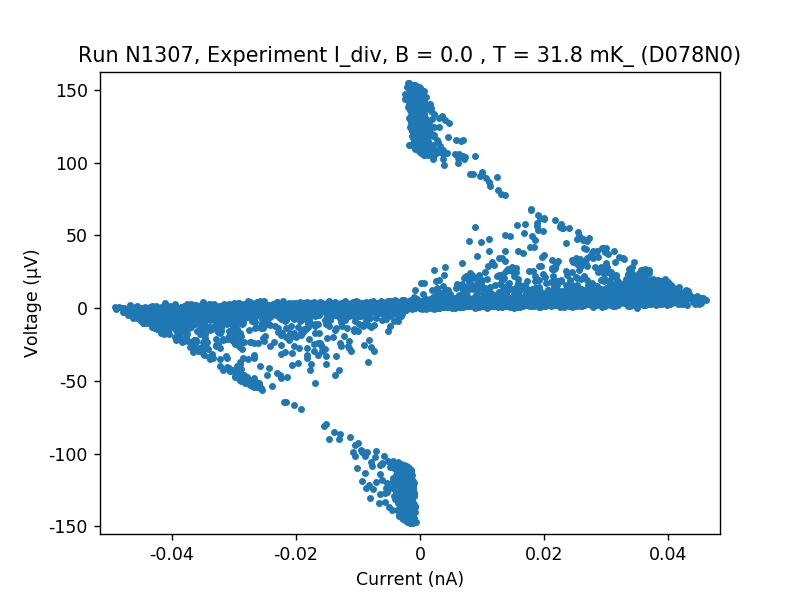

In [91]:
plot_by_id_corr(1307, I_corr)

<IPython.core.display.Javascript object>


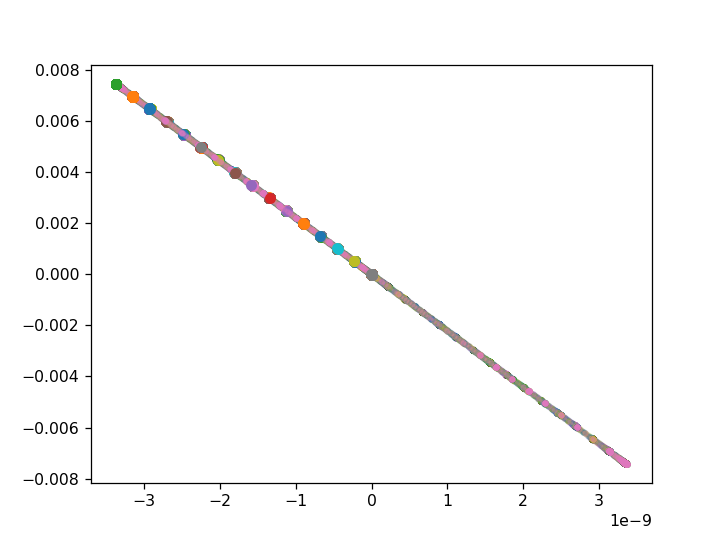

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


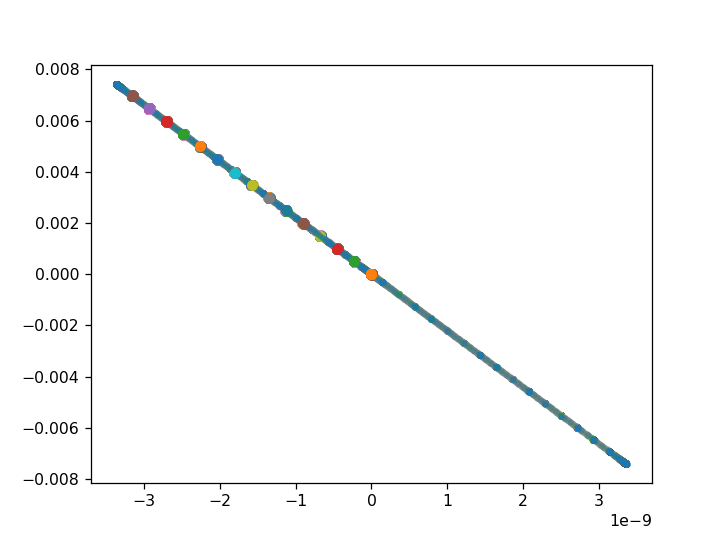

In [10]:
populate_exps (exps, ZF_ = ZF, FF_ = FF, VERBOSE = True,
                   N = 16, Gap = 497.5e-6, dy = 20e-6)

In [178]:

    
len(exps[0]['Isws_n'])

17

<IPython.core.display.Javascript object>


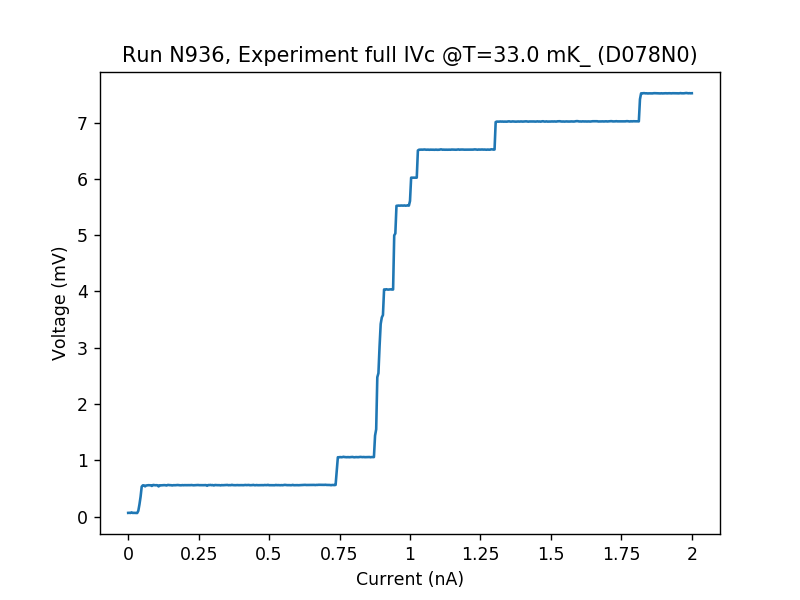

([<matplotlib.axes._subplots.AxesSubplot at 0x233c38a9eb8>], [None])

In [154]:
plot_by_id(936)

<IPython.core.display.Javascript object>


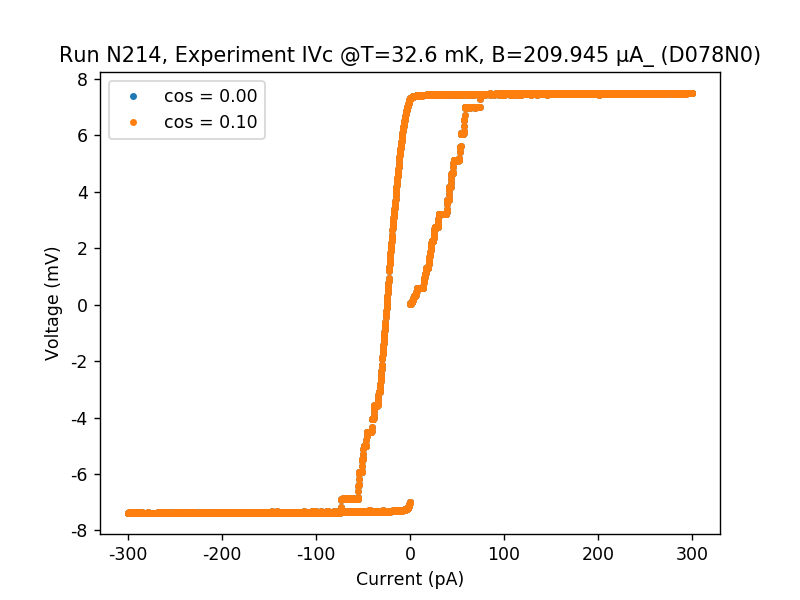

In [244]:
fig, ax = plt.subplots()
# exp = exps[0]
for cos in [0, 0.1]:
    exp = exps[0]
# for exp in exps[:-4]:
    ind = load_by_key(exp, 'cos', cos )
    
#     ax.plot(exp['Is_n'][ind][10], exp['Vs_n'][ind][10])
    plot_by_id(exp['ids'][ind], ax, marker = '.', ls ='', label = 'cos = {:1.2f}'.format(cos))
#     plot_by_key(exp, 'cos', cos, ax, ls = '')
ax.legend()

In [241]:
495*30/31

479.03225806451616

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


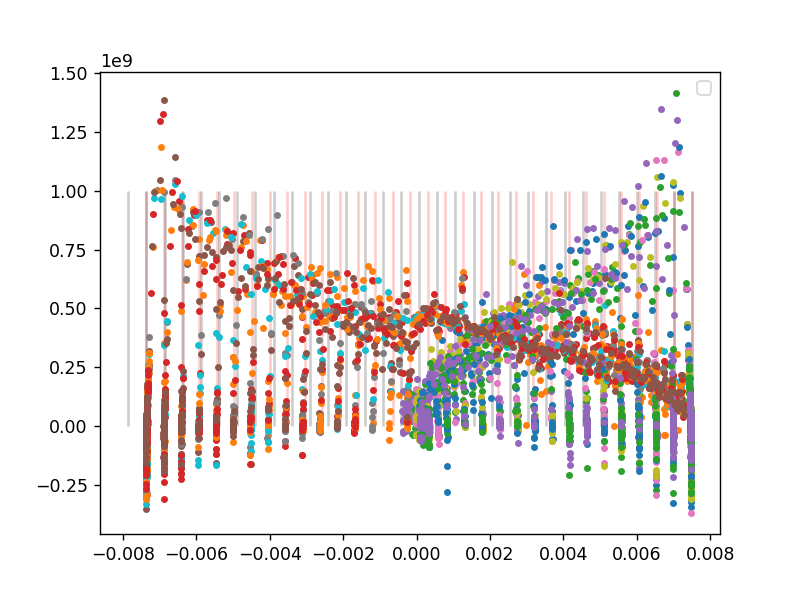

D:\anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
D:\anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


In [268]:
fig, ax = plt.subplots()
exp = exps[1]
for j, idx in enumerate(exp['ids'][::4]):
    B = exp['B'][j]
#     plot_by_id(idx, ax, marker = '.', ls ='', alpha=0.5)
#     plot_by_id(idx, ax, marker = '.', ls ='', label = 'B = {:1.0f}'.format(B*1e6))
    
    I, V = xy_by_id(idx)
    
    I0,_, I2,_ = np.array_split(I,4)
    V0,_, V2,_ = np.array_split(V,4)
    
    
#     a, b0 = np.polyfit( I0[-30:], V0[-30:],1)
#     a, b2 = np.polyfit( I2[-30:], V2[-30:],1)
    
#     Voff = 0e-6#b0+b2
    
    ax.plot(V0[:-1], np.diff(V0)/np.diff(I0), '.')
    ax.plot(V2[:-1], np.diff(V2)/np.diff(I2), '.')
    
ax.legend()

gap = 495.5e-6
offset = 68e-6
N = 15

for i in range(-N-1,N+1,1):
    ax.vlines(i*gap  +offset,                    -1e-9,1e9, alpha = 0.2)

    ax.vlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e9,
                   alpha = 0.2, color='r')


D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


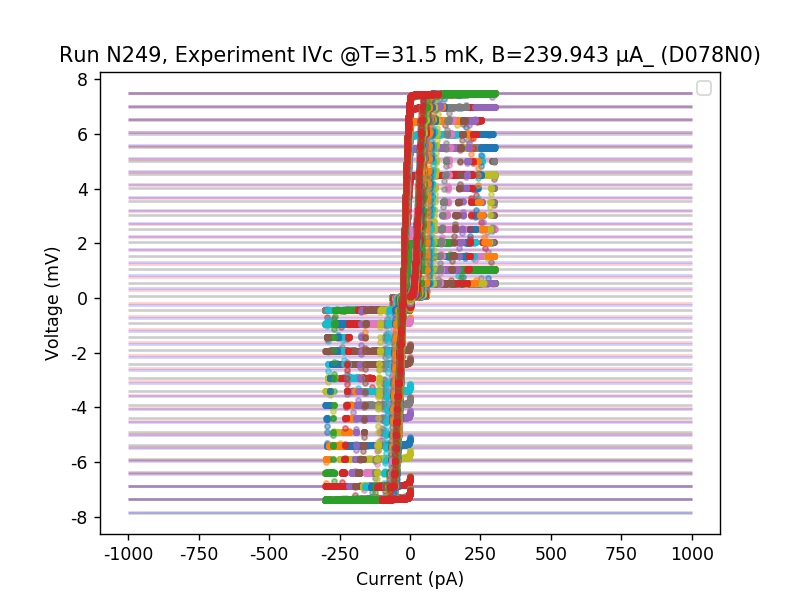

No handles with labels found to put in legend.


In [281]:
fig, ax = plt.subplots()

exp = exps[0]
for j, idx in enumerate(exp['ids'][:]):
    plot_by_id(idx, ax, marker = '.', ls ='', alpha=0.5)

exp = exps[1]
for j, idx in enumerate(exp['ids'][:]):
    plot_by_id(idx, ax, marker = '.', ls ='', alpha=0.5)
    
    
    
ax.legend()

gap = 495.5e-6
offset = 66e-6
N = 15

fr = 21e-6

for i in range(-N-1,N+1,1):
    ax.hlines(i*gap  +offset,                    -1e-9,1e-9, alpha = 0.2)

    ax.hlines( gap*(N*(2*i+1)/(2*N+1)) +offset, -1e-9,1e-9,
                   alpha = 0.2, color='r')
    
    
    if i == 0:
        ax.hlines( offset + fr*N, -1e-9,1e-9,
                       alpha = 0.2, color='b')
        ax.hlines( offset - fr*N, -1e-9,1e-9,
                       alpha = 0.2, color='b')
    else:
        k = np.sign(i)*(N - abs(i))
        ax.hlines( offset + gap*i + fr*k, -1e-9,1e-9,
                       alpha = 0.2, color='b')


In [277]:
np.sign(0)

0

<IPython.core.display.Javascript object>


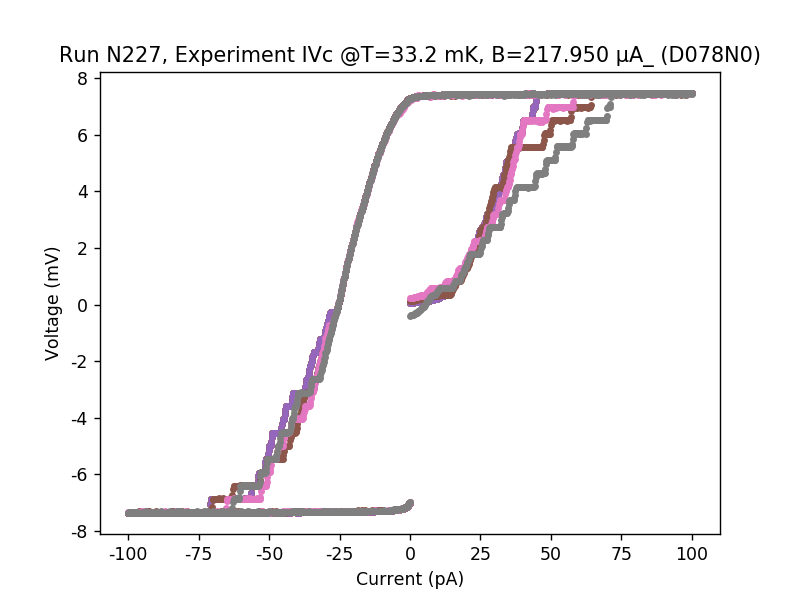

In [63]:
fig, ax = plt.subplots()
exp = exps[-2]
# for cos in exp['cos'][0:10]:
for cos in [1, .8, .6, 0.4, .3, .2, .1, 0]:
    ind = load_by_key(exp, 'cos', cos )
    
    plot_by_id(exp['ids'][ind], ax, marker = '.', ls ='')
#     plot_by_key(exp, 'cos', cos, ax, ls = '')

## Isw(cos)

<IPython.core.display.Javascript object>


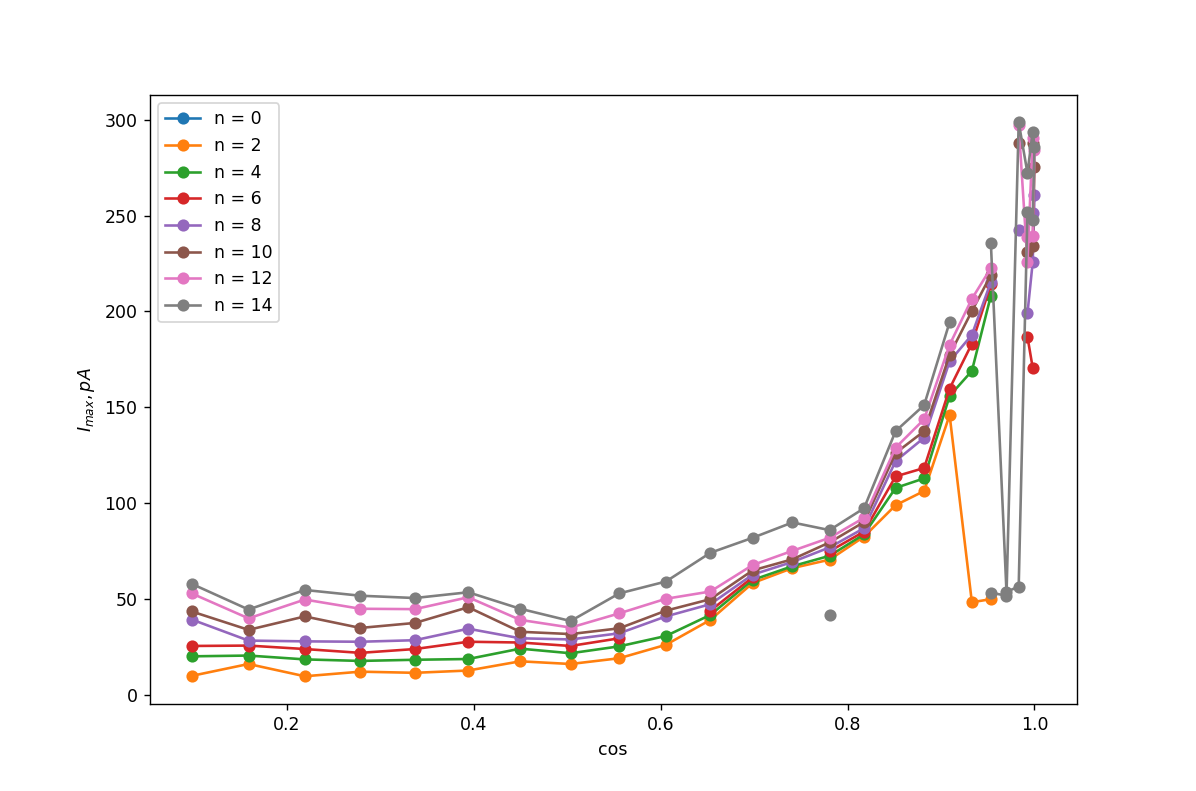

Text(0, 0.5, '$I_{max}, pA$')

In [81]:
fig, ax = plt.subplots()

exp = exps[0]


for i in range(0,16,2):
    ax.plot(exp ['cos' ] , exp['Isws_n'][i]*1e12, '-o', label = f'n = {i}')

# ax.set_yscale('log')    
ax.legend()

ax.set_xlabel(r'cos')
ax.set_ylabel(r'$I_{max}, pA$')



<IPython.core.display.Javascript object>


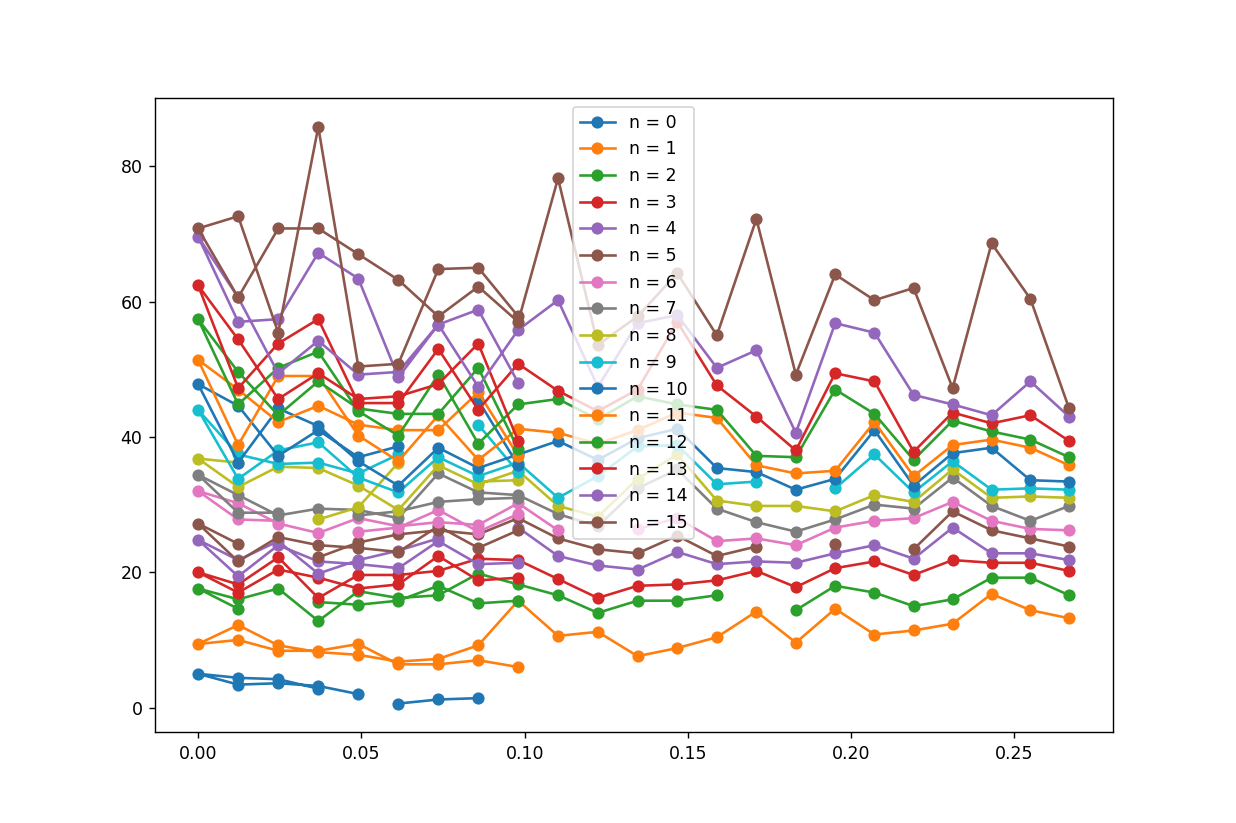

In [93]:
fig, ax = plt.subplots()

exp = exps[-2]


for i in range(16):
    ax.plot(exp ['cos' ] , exp['Isws_n'][i]*1e12, '-o', label = f'n = {i}')

    
ax.legend()

<IPython.core.display.Javascript object>


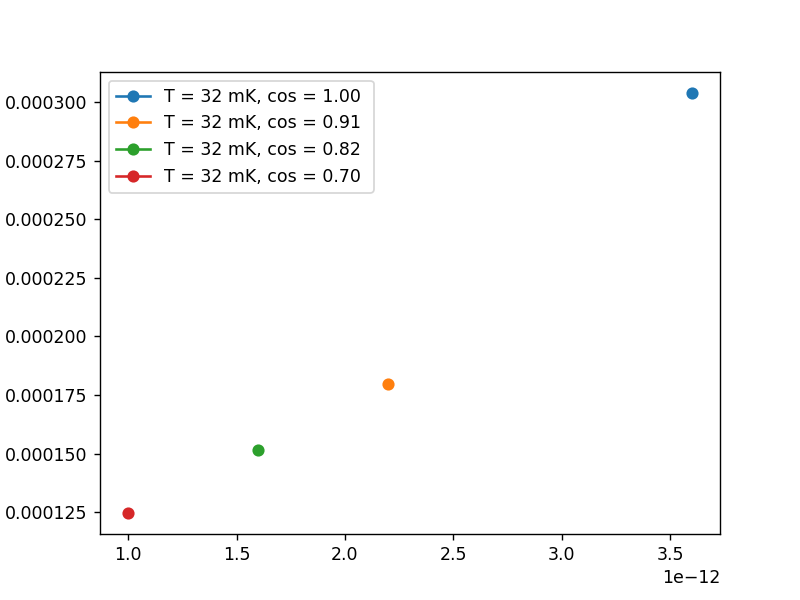

In [96]:
fig, ax = plt.subplots()

for cos in [1, .9, .8, 0.7]:

    plot_by_key(exps[0], 'cos', cos, ax,  ls = '-')



## R0(cos)

<IPython.core.display.Javascript object>


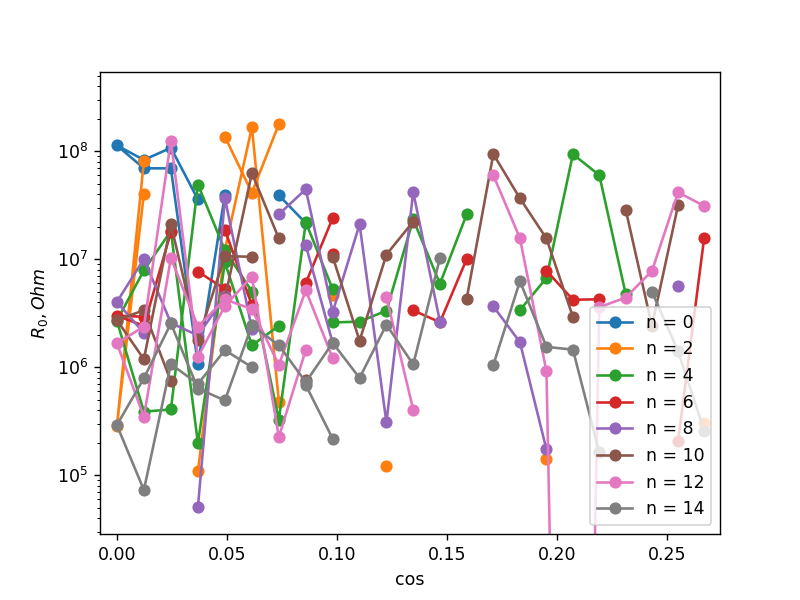

Text(0, 0.5, '$R_{0}, Ohm$')

In [141]:
fig, ax = plt.subplots()

exp = exps[1]


for i in range(0,16,2):
    ax.plot(exp ['cos' ] , exp['R0s_n'][i], '-o', label = f'n = {i}')

ax.set_yscale('log')    
ax.legend()

ax.set_xlabel(r'cos')
ax.set_ylabel(r'$R_{0}, Ohm$')



In [143]:
[1e-6]*3

[1e-06, 1e-06, 1e-06]

# Fine meas

In [11]:
ZF = 0.004e-3
FF = 0.218e-3
# dF = 0.250e-3
# midF = 0.154e-3


cos_list = cos_to_B(np.linspace(1,0,15))

keys  = [             'ids',    'T',    'B',                                 'comment']
valss = [
         [range(1307, 1336+1),  32e-3,  np.append(cos_to_B(np.linspace(1,0.35,14)),
                                                cos_to_B(np.linspace(0.375,0,16))), ''],
         [range(1338, 1352+1),  50e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1353, 1367+1), 100e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1368, 1382+1), 150e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1383, 1397+1), 200e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1398, 1412+1), 250e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1413, 1427+1), 300e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1428, 1442+1), 350e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1443, 1457+1), 400e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1458, 1472+1), 450e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],
         [range(1473, 1487+1), 500e-3,  cos_to_B(np.linspace(1,0,15)),        'np.nan'],

        ]

exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]
# exps78N0_pd = pd.DataFrame(  data  = list(zip(*valss)), index = keys ).transpose()

NameError: name 'cos_to_B' is not defined

<IPython.core.display.Javascript object>


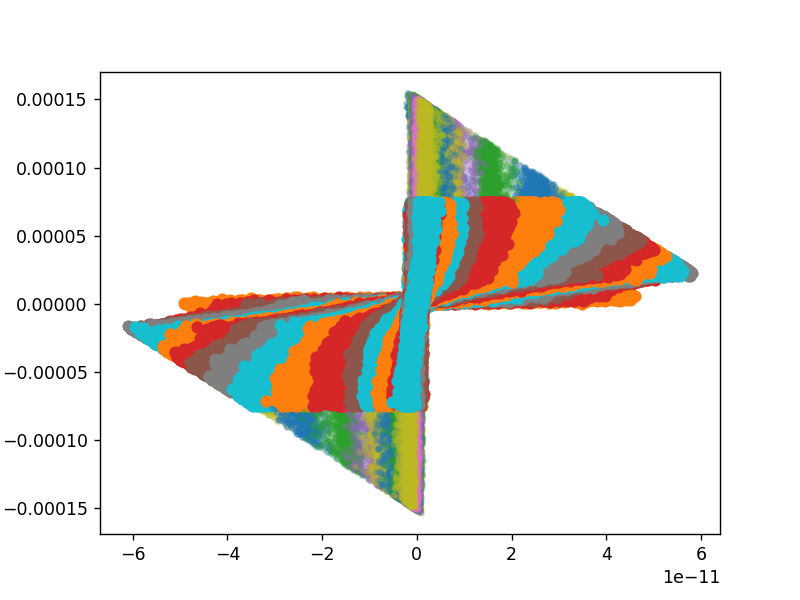

<IPython.core.display.Javascript object>


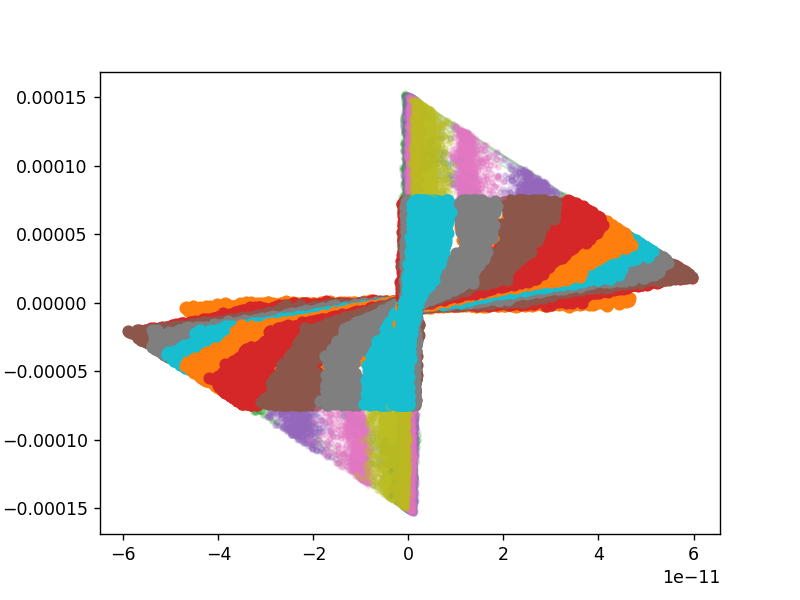

<IPython.core.display.Javascript object>


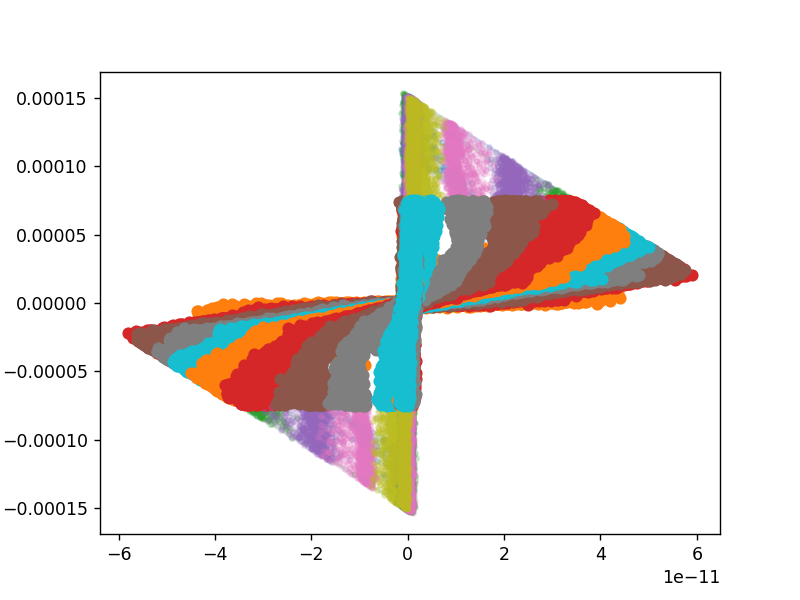

<IPython.core.display.Javascript object>


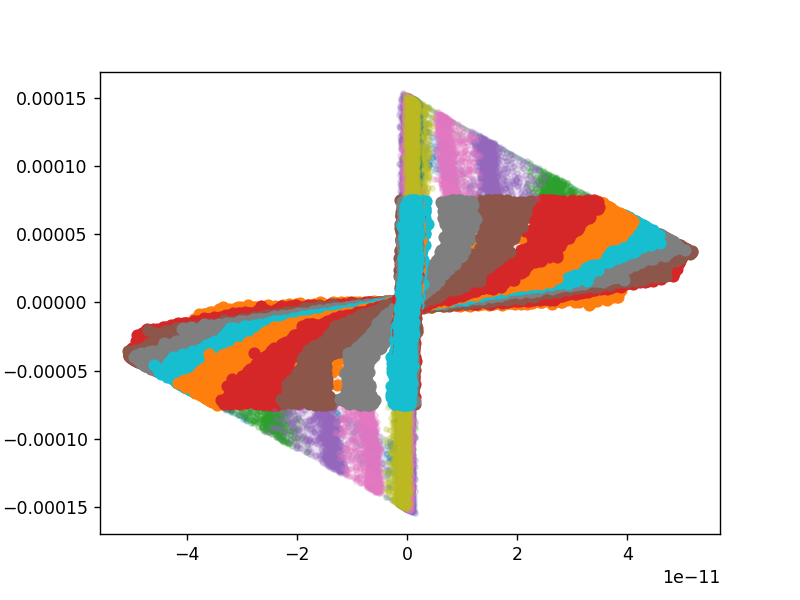

<IPython.core.display.Javascript object>


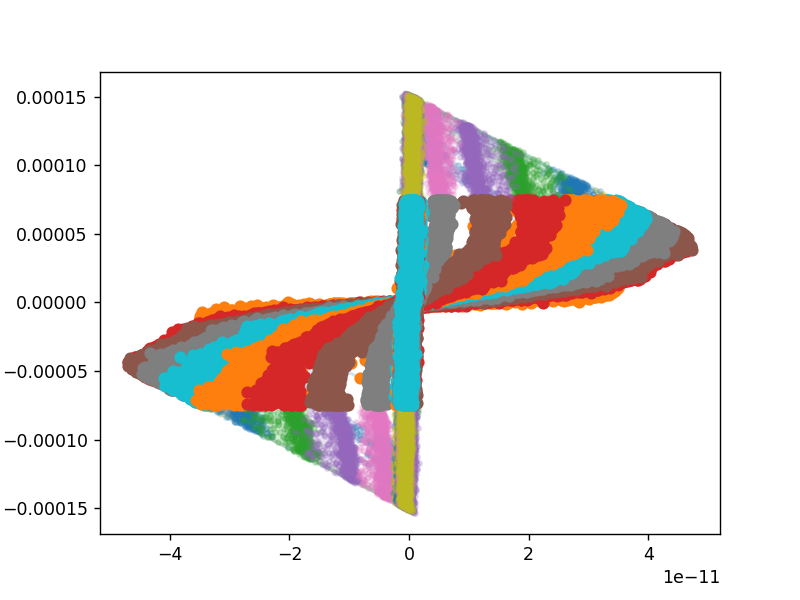

<IPython.core.display.Javascript object>


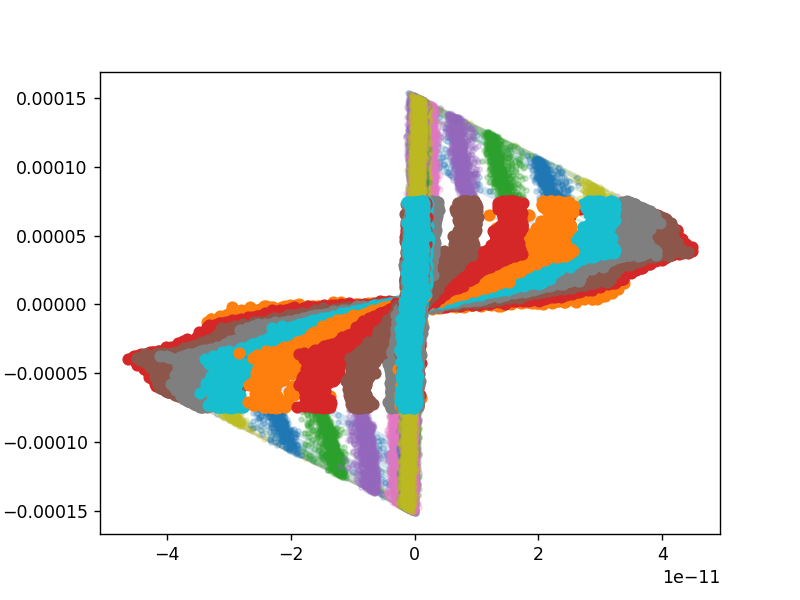

<IPython.core.display.Javascript object>


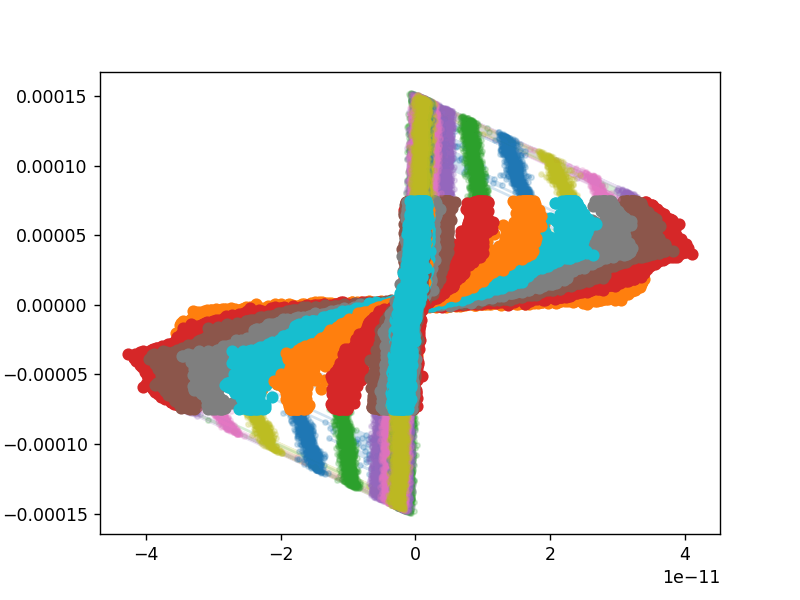

<IPython.core.display.Javascript object>


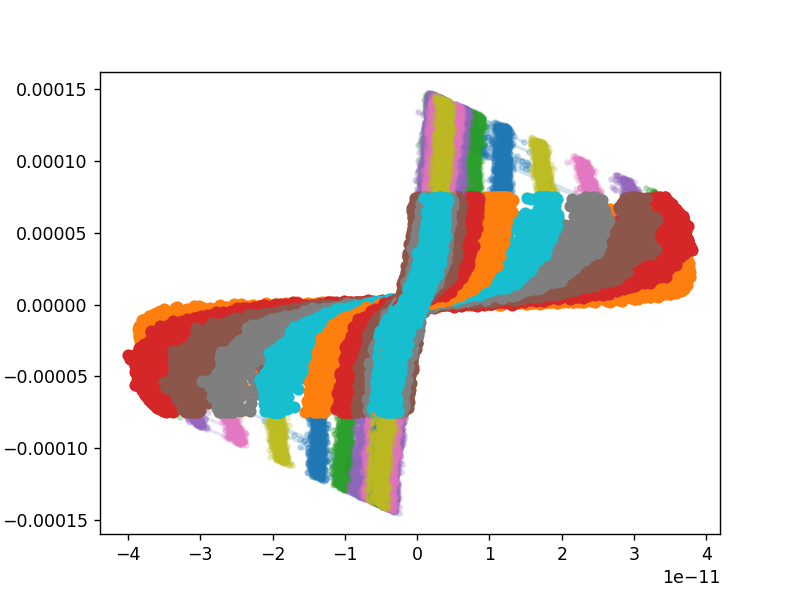

<IPython.core.display.Javascript object>


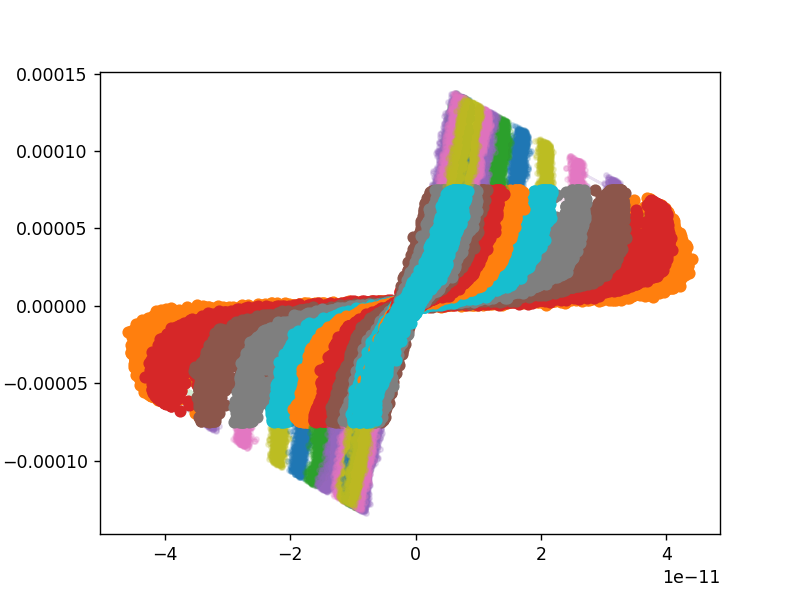

<IPython.core.display.Javascript object>


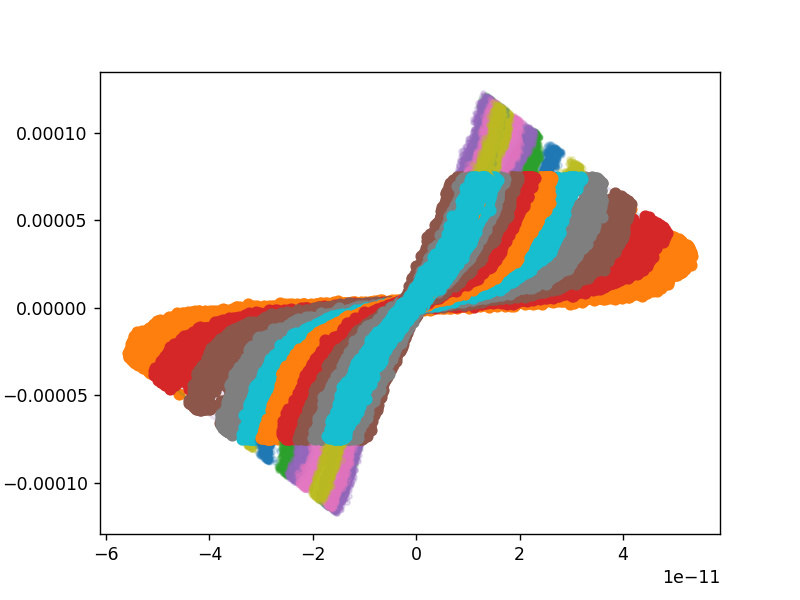

<IPython.core.display.Javascript object>


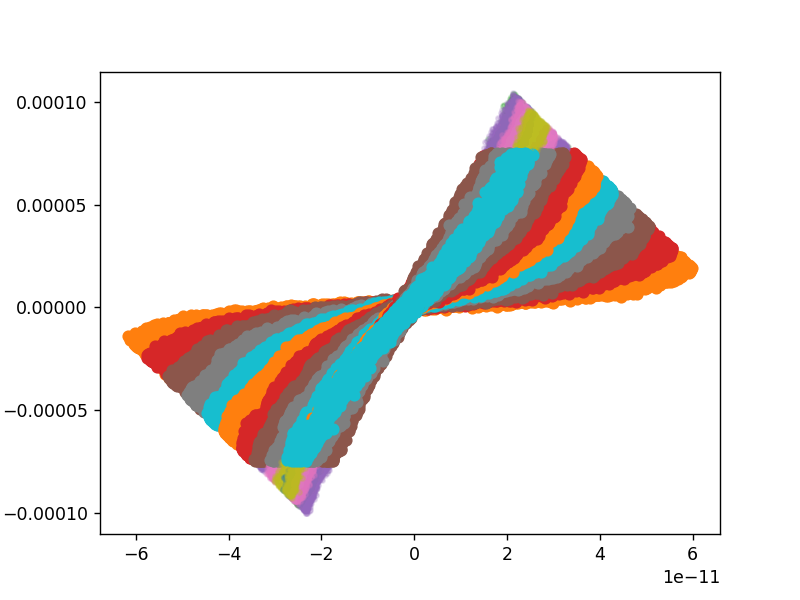

In [235]:
populate_exps (exps, ZF_ = ZF, FF_ = FF, VERBOSE = True,
                   N = 0, Gap = 497.5e-6, dy = 75e-6)

## Isws

<IPython.core.display.Javascript object>


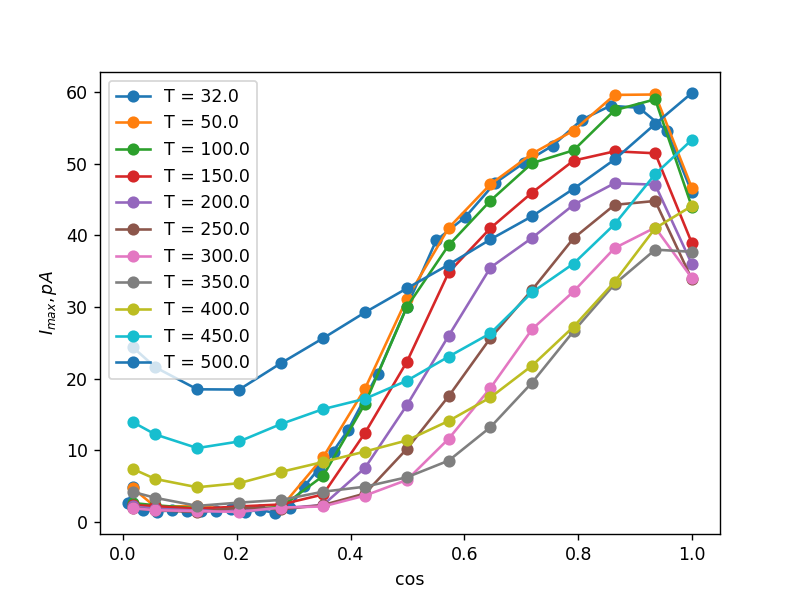

Text(0, 0.5, '$I_{max}, pA$')

In [236]:
fig, ax = plt.subplots()

exp = exps[0]


for exp in exps:
    Tb = exp['T']*1e3
    ax.plot(exp ['cos' ] , exp['Isws']*1e12, '-o', label = f'T = {Tb}')

# ax.set_yscale('log')    
ax.legend()

ax.set_xlabel(r'cos')
ax.set_ylabel(r'$I_{max}, pA$')



## IVCs

In [142]:
len(exp['Vs'][0])

6003

<IPython.core.display.Javascript object>


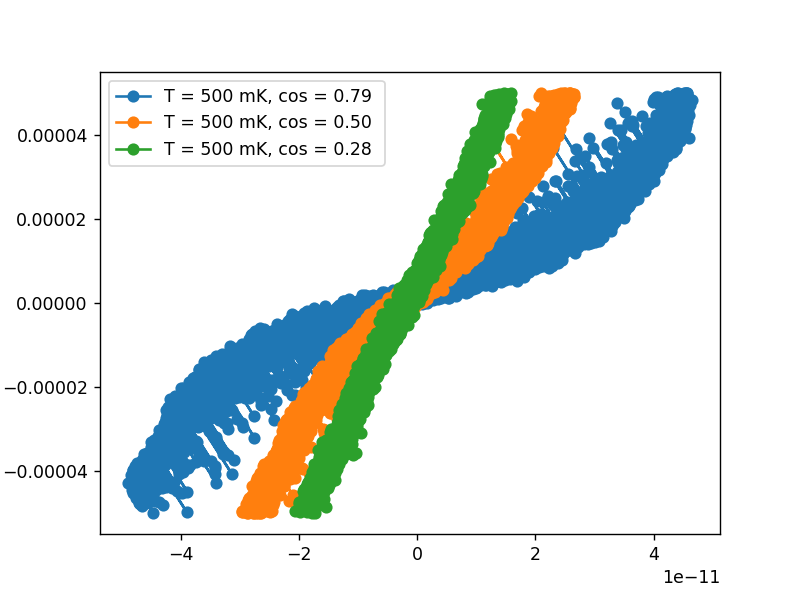

In [211]:
fig, ax = plt.subplots()

exp = exps[-1]

for cos in [0.8, 0.5, 0.3]:

    plot_by_key(exp, 'cos', cos, ax,  ls = '-')

## Fitting

<IPython.core.display.Javascript object>


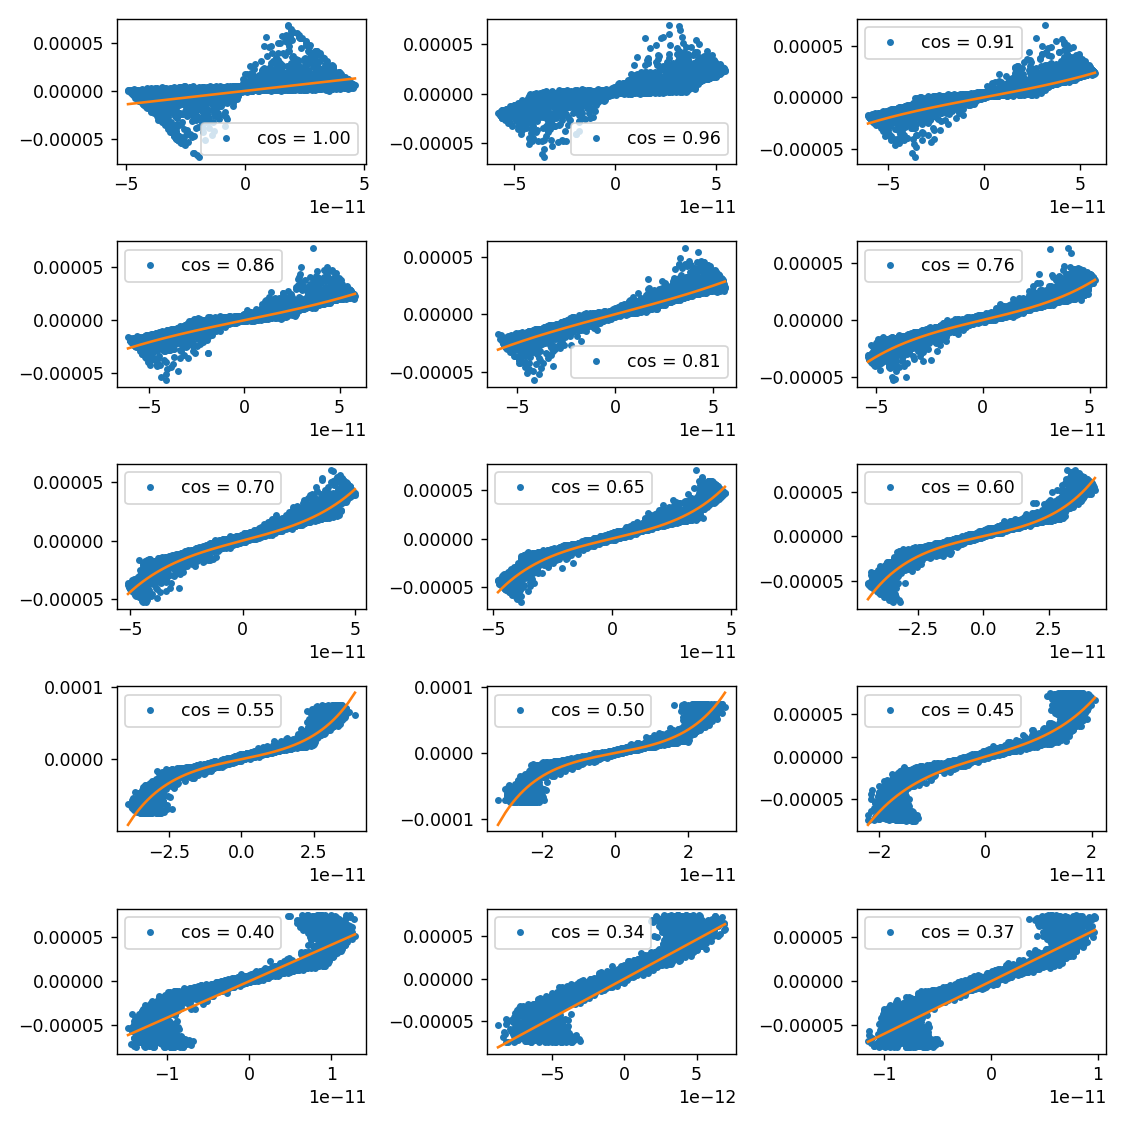

[1.63805505e+03 1.71983466e-01]
[nan, nan]
[20.19737007 17.31710568]
[23.27540495 15.99402065]
[31.35244073 14.58170545]
[14.71066201 30.60204334]
[13.38123951 37.89621847]
[12.81886019 45.1587137 ]
[11.68847865 56.99571611]
[11.97688902 69.66571917]
[11.58493085 91.99787618]
[19.00786324 97.21583744]
[985.62547848   4.19665807]
[1.15517851e+04 8.00997403e-01]
[1.31039873e+04 4.54758953e-01]


In [299]:

As = []
Bs = []
coss = []


exp = exps[0]

fig = plt.figure(figsize = (9,9))
gs = GridSpec.GridSpec(5, 3)
popt_try = ( 10 , 100)
for i in range(15):
    
    ax = fig.add_subplot(gs[i] )
    
    j = 1*i+0
    cos = exp['cos'][j]
    I, V = exp['Is'][j] , exp['Vs'][j]
    
    ax.plot( I, V , '.' ,label = 'cos = {:1.2f}'.format(cos))


    
    Tb = exp['T']
    
    V_fit = lambda x, A,B  : A*np.sinh(x*B) 
    
#     I_fit = lambda x, A,B  : x - I_IZ( x, EJ = A, R = B, T = .05)*B

    
 
#     ind_sort = np.argsort(V)
    
#     I = I[ind_sort][::50]
#     V = V[ind_sort][::50]
    
#     popt1 = (0.01,1e3)
#     try:
#         popt, pcov = curve_fit(I_fit, V, I , p0 = popt1 )
#         popt_try = popt
#     except RuntimeError: 
#         popt = [np.nan, np.nan]

#     Is = I_fit(V, *popt)
    
#     ax.plot(Is, (V  )) 
        
    ind_sort = np.argsort(I)
    
    I = I[ind_sort]
    V = V[ind_sort]
    popt1 = popt_try
 
    try:
        popt, pcov = curve_fit(V_fit, I/1e-9 ,V/1e-6, p0 = popt1 )
        popt_try = popt
    except RuntimeError: 
        popt = [np.nan, np.nan]

    Vs = V_fit(I/1e-9, *popt)*1e-6
    ax.plot(I, (Vs  ))
    
    
#     R = 1e4
#     VZ = V[::10]
#     IZ = I_IZ( VZ, EJ = .013*cos, R = R, T = Tb)
#     ax.plot(IZ, (VZ - IZ*R), '.')

    print(popt)
    
    A, B = popt[0], popt[1] 

    As.append(A)
    Bs.append(B)
    coss.append(cos)

    

    ax.legend()
    
plt.tight_layout()
    
As = np.array(As)
Bs = np.array(Bs)

coss = np.array(coss)

In [288]:
 I_IZ( np.array([1e-6]), EJ = .5, R = R, T = .05)

array([9.99999873e-11])

<IPython.core.display.Javascript object>


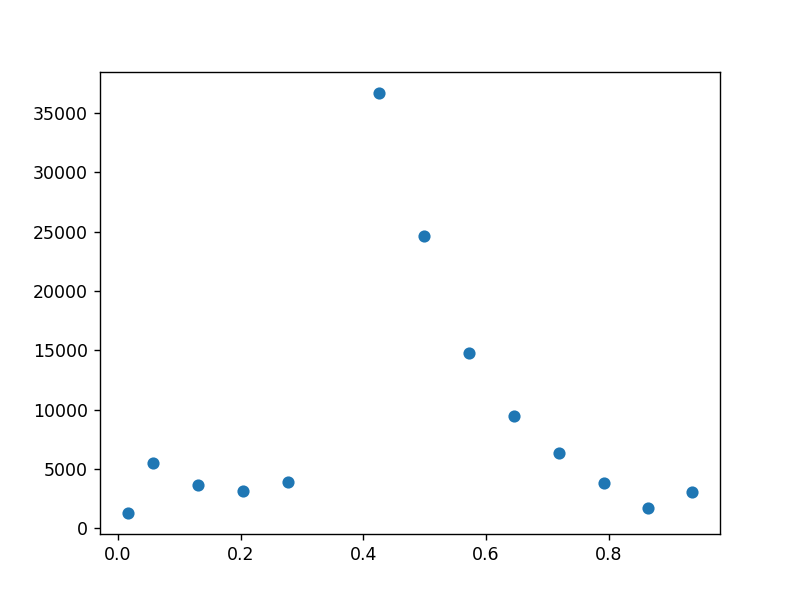

In [295]:
fig, ax = plt.subplots()

ax.plot(coss,Bs/1e-9 / 1e6, 'o')

<IPython.core.display.Javascript object>


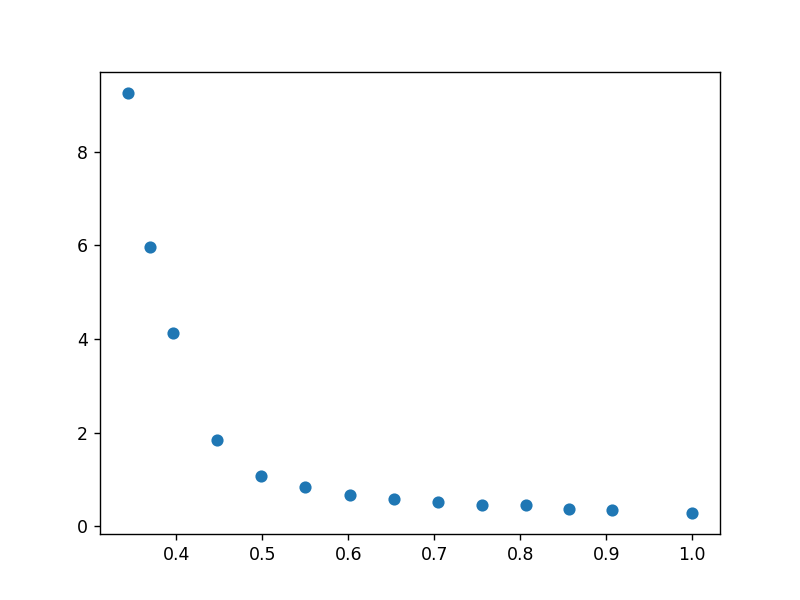

In [300]:
fig, ax = plt.subplots()

ax.plot(coss, As*1e-6*Bs/1e-9 / 1e6, 'o')

### lmfit with IZ function

In [379]:
from mpmath import besseli

Iν = np.frompyfunc(besseli, 2,1)

x = np.linspace(1,2,11)*1e-3


def  I_IZ_np( Vb, EJ, R, T):

    β = 1/T/kB
    ρ = R/RQ
    z = 1j*β*e*Vb/pi/ρ
    return np.array(2*e/hbar*EJ*kB * ( ((Iν(1-z, EJ/T) / Iν(-z, EJ/T))) ) , dtype = complex).imag
#    return np.array(2*e/hbar*EJ*kB * ( ((Iν(1-z, EJ/T) / Iν(-z, EJ/T)).imag) ) , dtype = float)

In [407]:
import lmfit as lmf

izmodel = lmf.Model(I_IZ_np)

izparams = izmodel.make_params(EJ=.05, R=1e4, T=.05)
izmodel.set_param_hint('EJ', min=0, max = 1)
izmodel.set_param_hint('R', min=1e3, max = 1e7)
izmodel.set_param_hint('T', min=0.03, max = 1)

In [381]:
def sinh (x, A, B, R):
    return A*np.sinh(x*B)


shmodel = lmf.Model(sinh)

params = shmodel.make_params(A= 1e-6, B = 1e9 )
shmodel.set_param_hint('A', min=0)
shmodel.set_param_hint('B', min=0)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


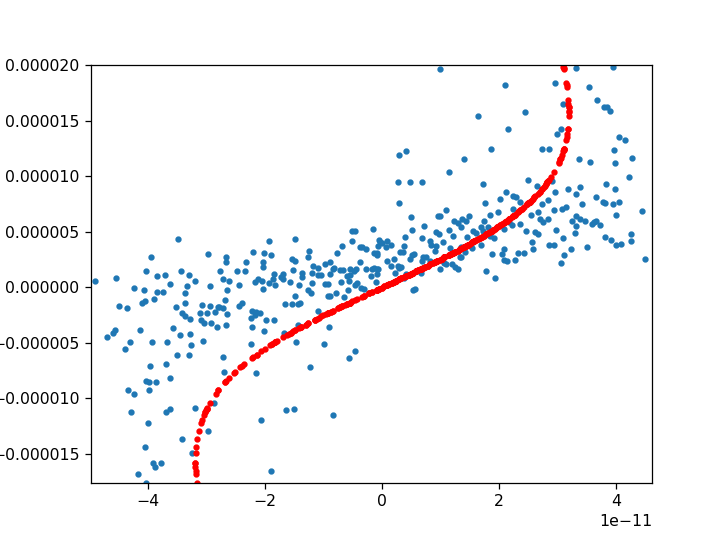

[[Model]]
    Model(I_IZ_np)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 439
    # variables        = 2
    chi-square         = 1.2470e-19
    reduced chi-square = 2.8535e-22
    Akaike info crit   = -21776.0672
    Bayesian info crit = -21767.8982
[[Variables]]
    EJ:  0.00991545 +/- 2.6181e-04 (2.64%) (init = 0.05)
    R:   11440.4057 +/- 994.084051 (8.69%) (init = 10000)
    T:   0.032 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(EJ, R) =  0.562


In [425]:


fig, ax = plt.subplots()


# for i in [-1, -2, -3,8]:
#     exp = exps[i]

exp = exps[0]


j = 0

I, V = exp['Is'][j][::10] , exp['Vs'][j][::10]
#I, V = xy_by_id(exp['ids'][j])

#V-=51e-6
#I = I[::100]
#V = V[::100]


Tb = exp['T']


izparams['T'].set( value = Tb, vary = False)
result = izmodel.fit(I, izparams, Vb=V)
#result = shmodel.fit(V, params, x=I)

print(result.fit_report())

ax.plot(I,V, '.')
#ax.plot(I,result.best_fit, 'r.', label='best fit')
ax.plot(result.best_fit, V, 'r.', label='best fit')
#ax.plot(result.init_fit, V, 'g.', label='init fit')


#ax.set_yscale('log')

In [427]:
10e-6/8e-11

125000.00000000001

D:\anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


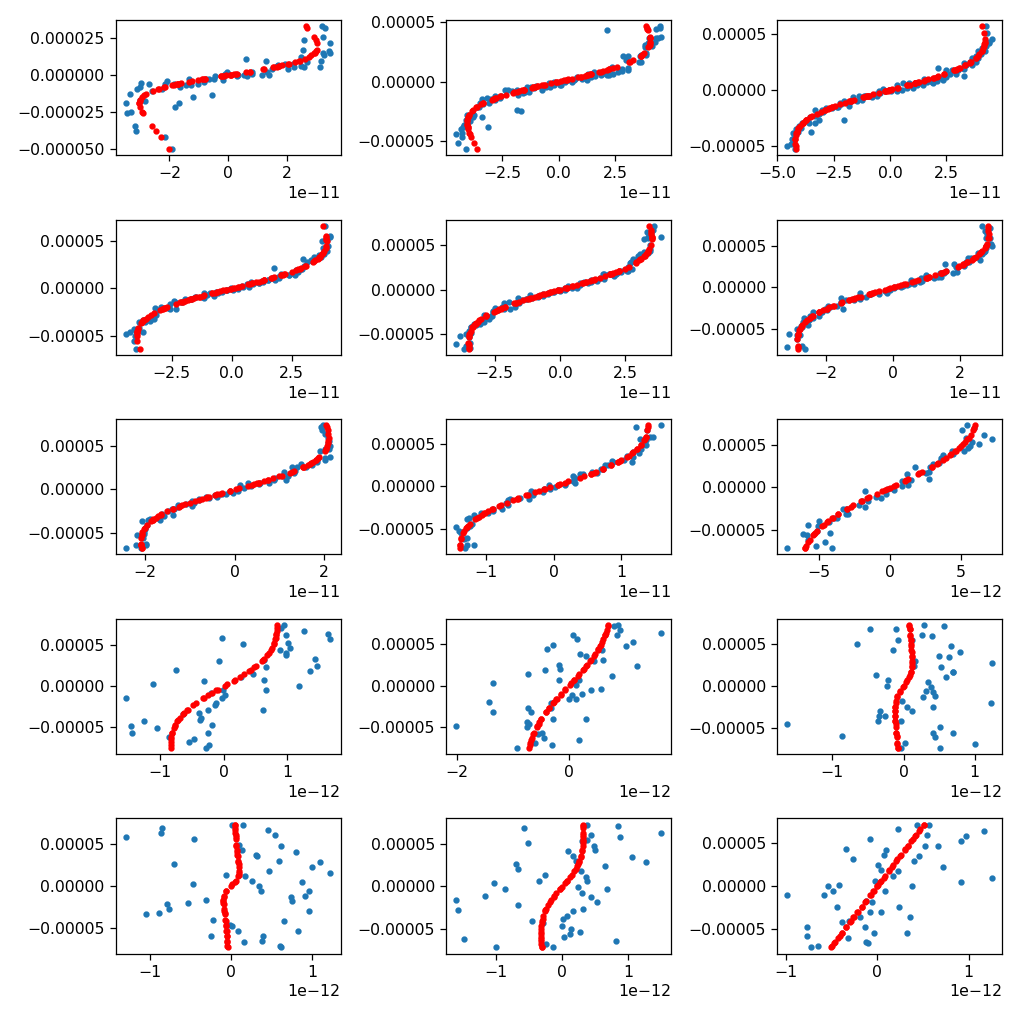


 curve # 0
{'EJ': 0.0240223420577864, 'R': 2305.33816336697, 'T': 0.2}

 curve # 1
{'EJ': 0.027780997622571153, 'R': 4126.53279476006, 'T': 0.2}

 curve # 2
{'EJ': 0.02833952470172328, 'R': 5330.153985421507, 'T': 0.2}

 curve # 3
{'EJ': 0.027488842181624666, 'R': 5878.36914456141, 'T': 0.2}

 curve # 4
{'EJ': 0.025886521493237835, 'R': 6794.873264375572, 'T': 0.2}

 curve # 5
{'EJ': 0.023364013163116544, 'R': 7592.139003949684, 'T': 0.2}

 curve # 6
{'EJ': 0.020002781121357536, 'R': 7109.68511853543, 'T': 0.2}

 curve # 7
{'EJ': 0.01625746136557818, 'R': 8598.163332560363, 'T': 0.2}

 curve # 8
{'EJ': 0.01092522144307819, 'R': 11580.277006612461, 'T': 0.2}

 curve # 9
{'EJ': 0.00399233785015315, 'R': 8618.429552743608, 'T': 0.2}

 curve # 10
{'EJ': 0.0038313378343768144, 'R': 13265.835528528583, 'T': 0.2}

 curve # 11
{'EJ': 0.0015101575585439227, 'R': 3501.474880231887, 'T': 0.2}

 curve # 12
{'EJ': -0.0013576562538544661, 'R': 2155.702883326319, 'T': 0.2}

 curve # 13
{'EJ': 0.0024

In [421]:

EJs = []
Rs = []
Ts = []
coss = []


exp = exps[4]

fig = plt.figure(figsize = (9,9))
gs = GridSpec.GridSpec(5, 3)

for i in tqdm_notebook(range(15)):
    
    ax = fig.add_subplot(gs[i] )
    
    j = 1*i+0
    cos = exp['cos'][j]
    I, V = exp['Is'][j][::60] , exp['Vs'][j][::60]
    
    ax.plot( I, V , '.' ,label = 'cos = {:1.2f}'.format(cos))
    
    Tb = exp['T']
   
#     izmodel.set_param_hint('T', value = Tb, vary = False)
    izparams['T'].set( value = Tb, vary = False)
    result = izmodel.fit(I, izparams, Vb=V)

    print(f'\n curve # {i}')
    print(result.best_values)

    ax.plot(result.best_fit, V, 'r.', label='best fit')

    EJs.append(result.best_values['EJ'])
    Rs.append(result.best_values['R'])
    Ts.append(result.best_values['T'])
    coss.append(cos)
    
plt.tight_layout()
    


D:\anaconda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


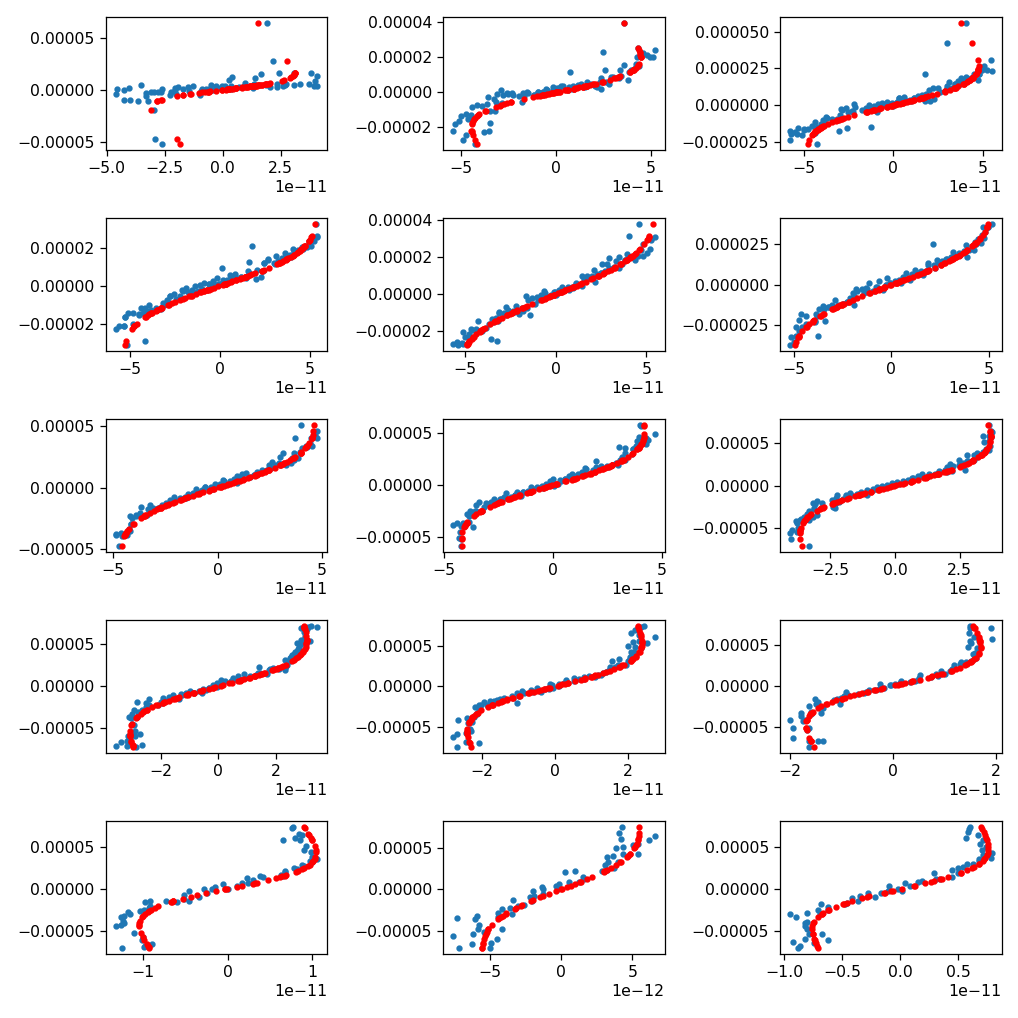


 curve # 0
{'EJ': 0.009792265134378872, 'R': 12410.355479200982, 'T': 0.032}

 curve # 1
{'EJ': 0.011760811553526353, 'R': 14426.156135743617, 'T': 0.032}

 curve # 2
{'EJ': 0.012185601784507524, 'R': 20039.326682144503, 'T': 0.032}

 curve # 3
{'EJ': 0.012831505043174034, 'R': 24758.04927823954, 'T': 0.032}

 curve # 4
{'EJ': 0.012916601671220749, 'R': 30679.115211047814, 'T': 0.032}

 curve # 5
{'EJ': 0.012506443046514755, 'R': 32594.682489969386, 'T': 0.032}

 curve # 6
{'EJ': 0.011922487890192993, 'R': 35704.32893555344, 'T': 0.032}

 curve # 7
{'EJ': 0.011382142146671926, 'R': 37479.698370143014, 'T': 0.032}

 curve # 8
{'EJ': 0.010667950275550233, 'R': 41600.07278420106, 'T': 0.032}

 curve # 9
{'EJ': 0.009742313769047665, 'R': 40637.63162648245, 'T': 0.032}

 curve # 10
{'EJ': 0.008574504608626795, 'R': 40101.573858970885, 'T': 0.032}

 curve # 11
{'EJ': 0.007209924444255556, 'R': 35243.159797062624, 'T': 0.032}

 curve # 12
{'EJ': 0.005662344691080919, 'R': 31926.4615123143, '

In [409]:

EJs = []
Rs = []
Ts = []
coss = []


exp = exps[0]

fig = plt.figure(figsize = (9,9))
gs = GridSpec.GridSpec(5, 3)

for i in tqdm_notebook(range(15)):
    
    ax = fig.add_subplot(gs[i] )
    
    j = 1*i+0
    cos = exp['cos'][j]
    I, V = exp['Is'][j][::60] , exp['Vs'][j][::60]
    
    ax.plot( I, V , '.' ,label = 'cos = {:1.2f}'.format(cos))
    
    Tb = exp['T']
   
#     izmodel.set_param_hint('T', value = Tb, vary = False)
    izparams['T'].set( value = Tb, vary = False)
    result = izmodel.fit(I, izparams, Vb=V)

    print(f'\n curve # {i}')
    print(result.best_values)

    ax.plot(result.best_fit, V, 'r.', label='best fit')

    EJs.append(result.best_values['EJ'])
    Rs.append(result.best_values['R'])
    Ts.append(result.best_values['T'])
    coss.append(cos)
    
plt.tight_layout()
    


D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


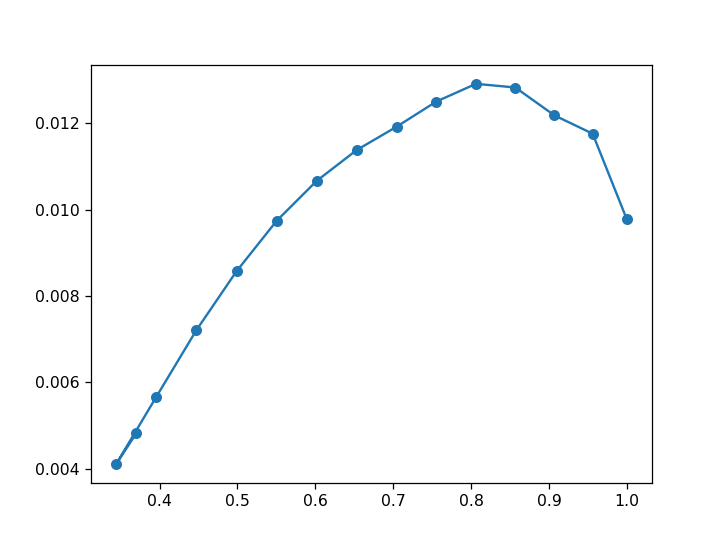

In [412]:
fig, ax = plt.subplots()

ax.plot(coss, EJs, 'o-')

# ax.set_yscale('log')

In [394]:
result.best_values

{'EJ': 0.0004315791362468365,
 'R': 3290036.3130446514,
 'T': 0.0001760798829320081}

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


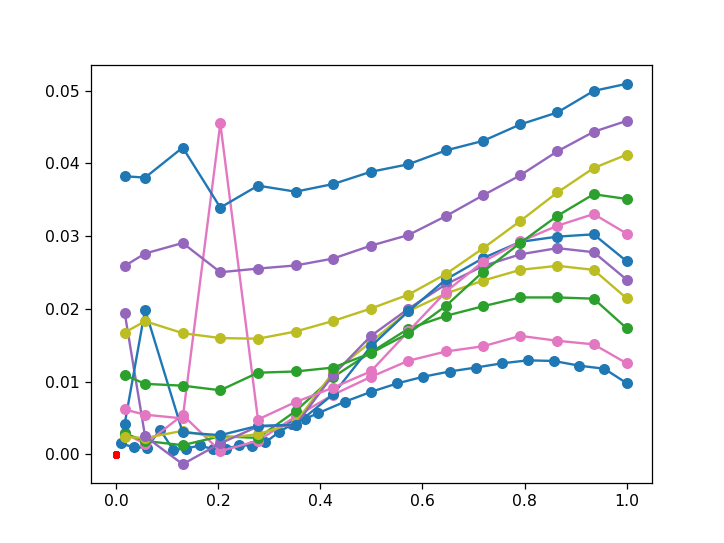


 curve # 14
{'EJ': 0.009792265134378872, 'R': 12410.355479200982, 'T': 0.032}

 curve # 14
{'EJ': 0.011760811553526353, 'R': 14426.156135743617, 'T': 0.032}

 curve # 14
{'EJ': 0.012185601784507524, 'R': 20039.326682144503, 'T': 0.032}

 curve # 14
{'EJ': 0.012831505043174034, 'R': 24758.04927823954, 'T': 0.032}

 curve # 14
{'EJ': 0.012916601671220749, 'R': 30679.115211047814, 'T': 0.032}

 curve # 14
{'EJ': 0.012506443046514755, 'R': 32594.682489969386, 'T': 0.032}

 curve # 14
{'EJ': 0.011922487890192993, 'R': 35704.32893555344, 'T': 0.032}

 curve # 14
{'EJ': 0.011382142146671926, 'R': 37479.698370143014, 'T': 0.032}

 curve # 14
{'EJ': 0.010667950275550233, 'R': 41600.07278420106, 'T': 0.032}

 curve # 14
{'EJ': 0.009742313769047665, 'R': 40637.63162648245, 'T': 0.032}

 curve # 14
{'EJ': 0.008574504608626795, 'R': 40101.573858970885, 'T': 0.032}

 curve # 14
{'EJ': 0.007209924444255556, 'R': 35243.159797062624, 'T': 0.032}

 curve # 14
{'EJ': 0.005662344691080919, 'R': 31926.461

In [414]:


fig, ax = plt.subplots()

EJss = []
Rss = []
Tss = []
cosss = []

for exp in tqdm_notebook(exps):
    

    EJs = []
    Rs = []
    Ts = []
    coss = []


    for j, cos in enumerate(exp['cos']):


        I, V = exp['Is'][j][::60] , exp['Vs'][j][::60]

        ax.plot( I, V , '.' ,label = 'cos = {:1.2f}'.format(cos))

        Tb = exp['T']

    #     izmodel.set_param_hint('T', value = Tb, vary = False)
        izparams['T'].set( value = Tb, vary = False)
        result = izmodel.fit(I, izparams, Vb=V)

        print(f'\n curve # {i}')
        print(result.best_values)

        ax.plot(result.best_fit, V, 'r.', label='best fit')

        EJs.append(result.best_values['EJ'])
        Rs.append(result.best_values['R'])
        Ts.append(result.best_values['T'])
        coss.append(cos)

    EJss.append(EJs)
    Rss.append(Rs)
    Tss.append(Ts)
    cosss.append(coss)
        
    ax.plot(coss, EJs, 'o-')
    
    
# ax.set_yscale('log')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


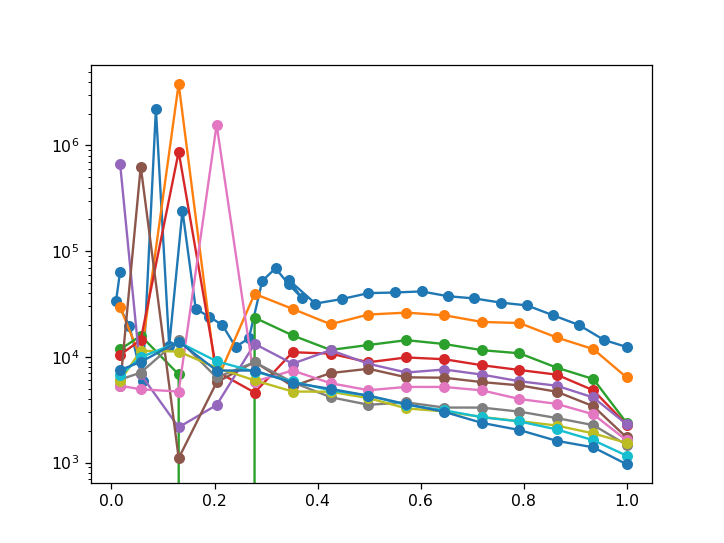

In [429]:
fig, ax = plt.subplots()

ys = Rss

for y,x in zip(ys, cosss):
    
    ax.plot(x,y, 'o-')
    
ax.set_yscale('log')

### curve fit

<IPython.core.display.Javascript object>


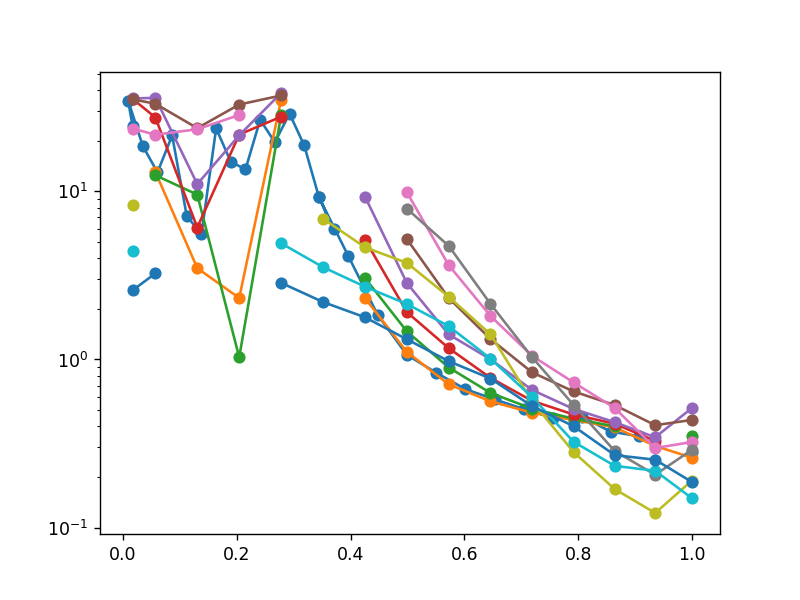

D:\anaconda\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [301]:


fig, ax = plt.subplots()


# for i in [-1, -2, -3,8]:
#     exp = exps[i]
for exp in exps:
    

    As = []
    Bs = []
    coss = []

    # exp = exps[-2]
    popt_try = ( 10 , 100)
    for j, cos in enumerate(exp['cos']):

        I, V = exp['Is'][j] , exp['Vs'][j]

        Tb = exp['T']

        V_fit = lambda x, A,B  : A*np.sinh(x*B)
    #     V_fit = lambda x, A,B  : A*cos**2*np.sinh(x*B*cos**2/Tb)

        popt1 = popt_try#( 10 , 50)
    
    
        ind_sort = np.argsort(I)

        I = I[ind_sort]
        V = V[ind_sort]
        try:
            popt, pcov = curve_fit(V_fit, I/1e-9 ,V/1e-6, p0 = popt1 )
            popt_try = popt
        except RuntimeError: 
            popt = [np.nan, np.nan]
        except TypeError: 
            popt = [np.nan, np.nan]    
        
        
#         print(popt, cos)

        A, B = popt[0], popt[1] 

        As.append(A)
        Bs.append(B)
        coss.append(cos)

    As = np.array(As)
    Bs = np.array(Bs)

    coss = np.array(coss)



    ax.plot(coss, As*1e-6*Bs/1e-9 / 1e6, 'o-')
    
    
ax.set_yscale('log')

# Hist

In [181]:
exp['Isws_n'][1]

array([3.2e-11, 4.4e-11,     nan, 4.4e-11,     nan,     nan, 3.6e-11,
           nan,     nan,     nan, 3.2e-11,     nan, 3.2e-11, 4.4e-11,
           nan,     nan, 4.0e-11,     nan,     nan,     nan,     nan,
       4.0e-11,     nan,     nan,     nan,     nan,     nan,     nan,
       4.0e-11, 3.6e-11,     nan,     nan, 2.8e-11, 3.6e-11, 4.0e-11,
       3.2e-11,     nan, 4.0e-11,     nan,     nan,     nan,     nan,
           nan, 4.0e-11,     nan, 2.0e-11, 4.0e-11,     nan, 4.0e-11,
           nan, 4.0e-11, 4.0e-11,     nan, 4.0e-11, 3.2e-11, 4.0e-11,
       4.4e-11, 4.0e-11,     nan,     nan,     nan,     nan,     nan,
           nan, 3.2e-11,     nan,     nan,     nan, 4.4e-11,     nan,
       3.2e-11,     nan,     nan, 4.4e-11,     nan, 4.0e-11,     nan,
       2.8e-11, 3.6e-11,     nan, 3.6e-11,     nan,     nan, 2.8e-11,
       3.6e-11,     nan, 2.4e-11, 2.8e-11, 2.8e-11, 3.2e-11, 3.6e-11,
           nan,     nan, 3.6e-11, 3.2e-11,     nan,     nan, 3.6e-11,
           nan,     

<IPython.core.display.Javascript object>


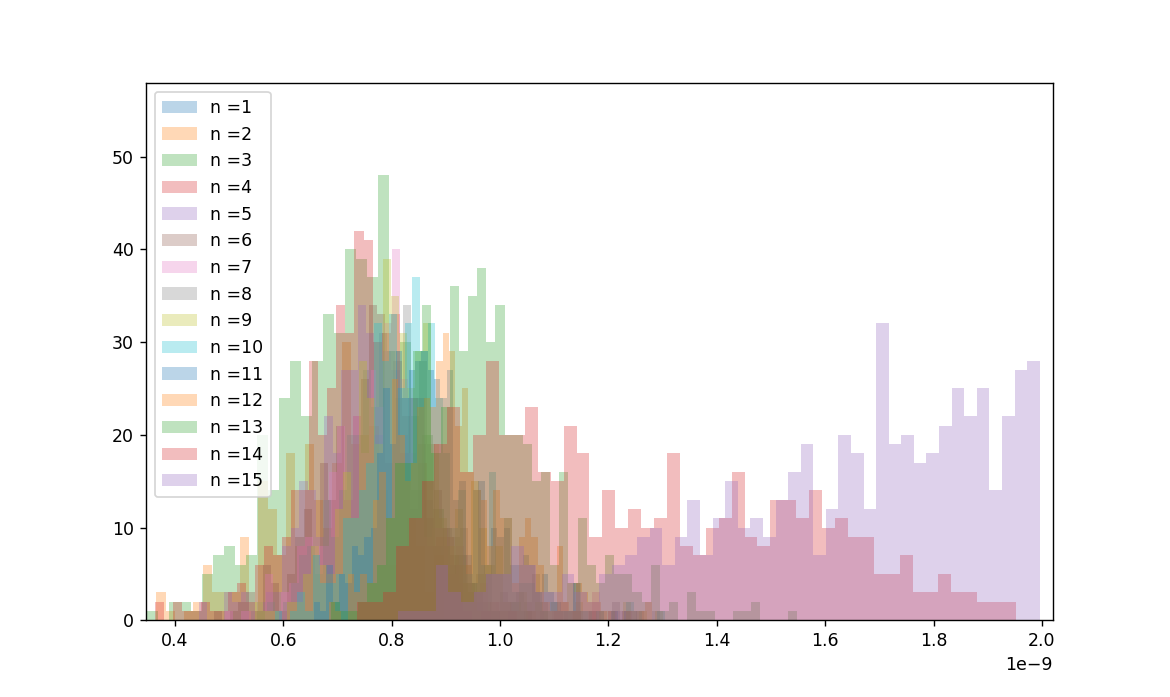

D:\anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [219]:
fig, ax = plt.subplots()

exp = exps[0]
for i in range(1,16, 1):
    Isws = exp['Isws_n'][i]
    ax.hist(Isws, bins = 51, alpha = 0.3, label = f'n ={i}')
    
ax.legend()

<IPython.core.display.Javascript object>


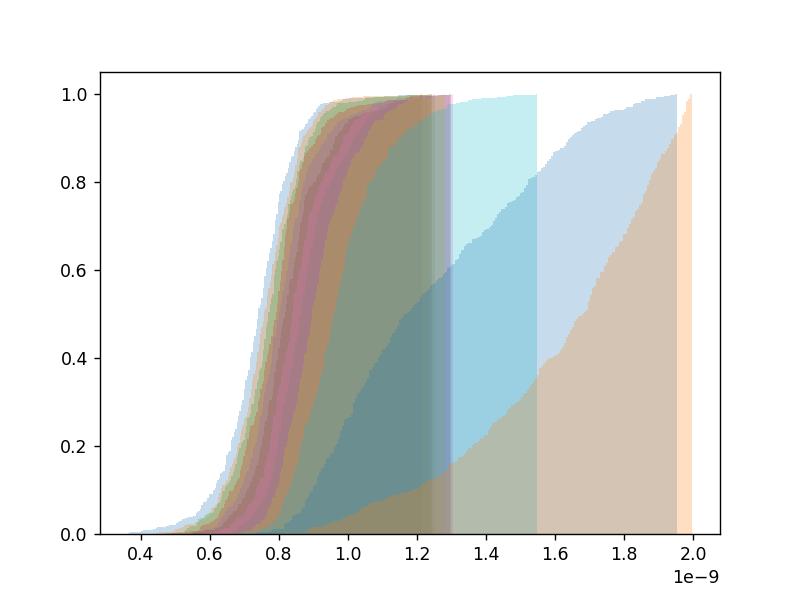

D:\anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [216]:
fig, ax = plt.subplots()

exp = exps[0]
for i in range(4,16, 1):
    Isws = exp['Isws_n'][i]
    ax.hist(abs(Isws), bins = 201, cumulative = True,  density = True, alpha = 0.25)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
D:\anaconda\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


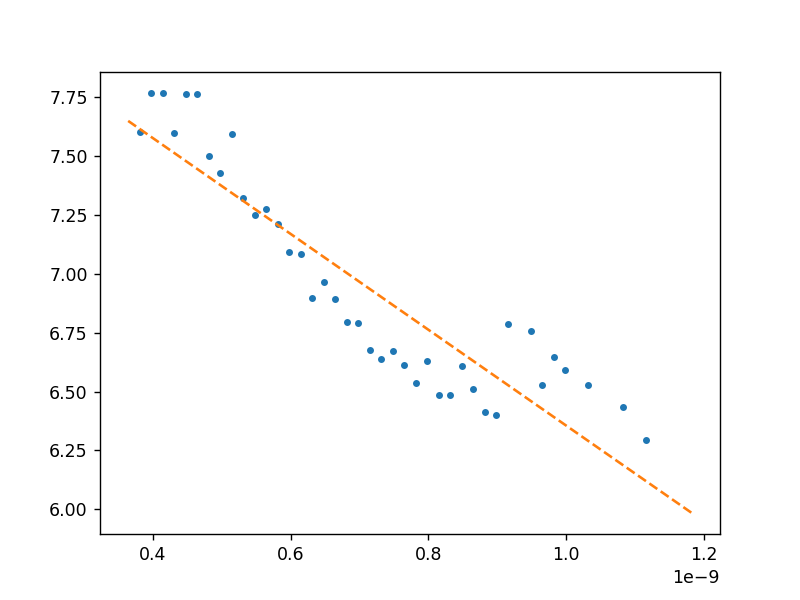

Ic0 = 2.7 nA
Teff = 4.5 mK


<IPython.core.display.Javascript object>


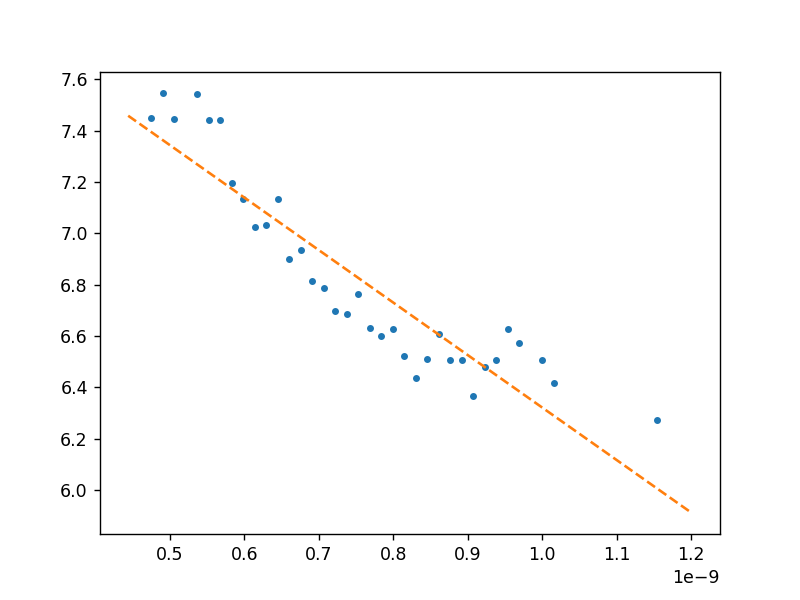

Ic0 = 2.8 nA
Teff = 4.7 mK


<IPython.core.display.Javascript object>


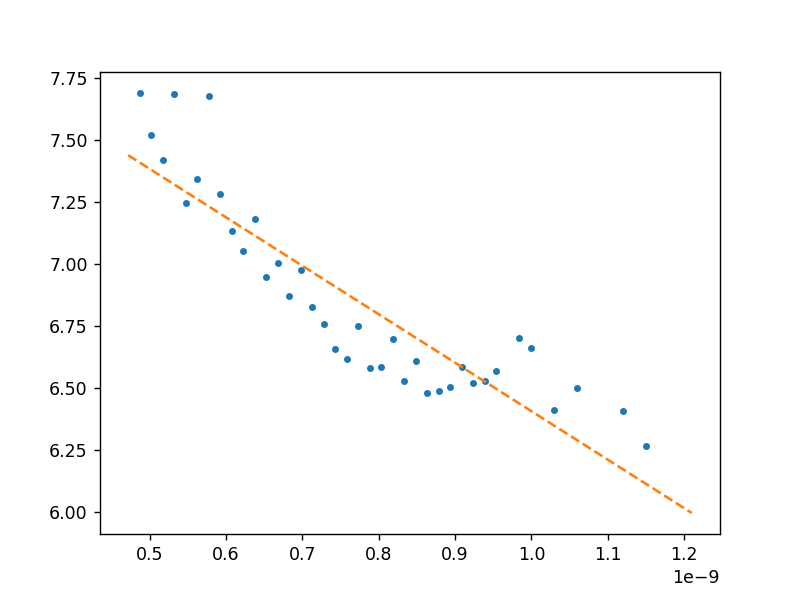

Ic0 = 2.8 nA
Teff = 4.5 mK


<IPython.core.display.Javascript object>


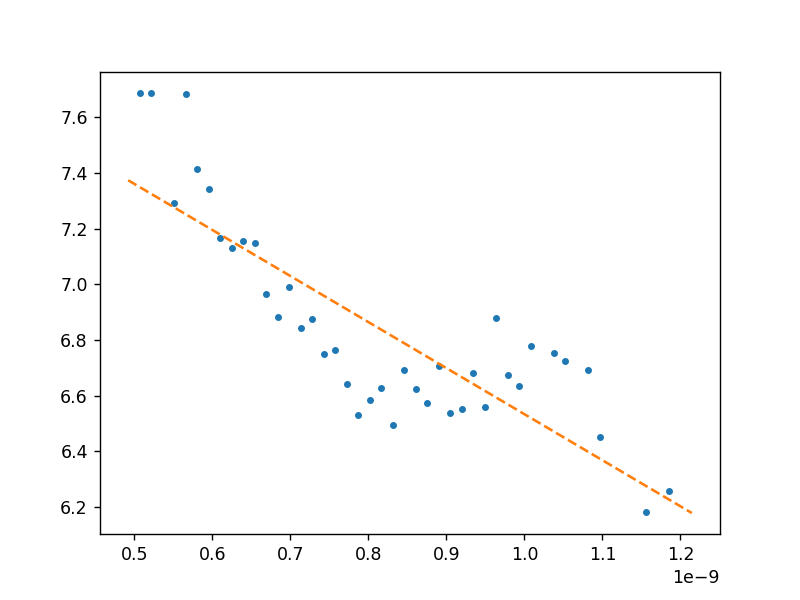

Ic0 = 2.7 nA
Teff = 4.2 mK


<IPython.core.display.Javascript object>


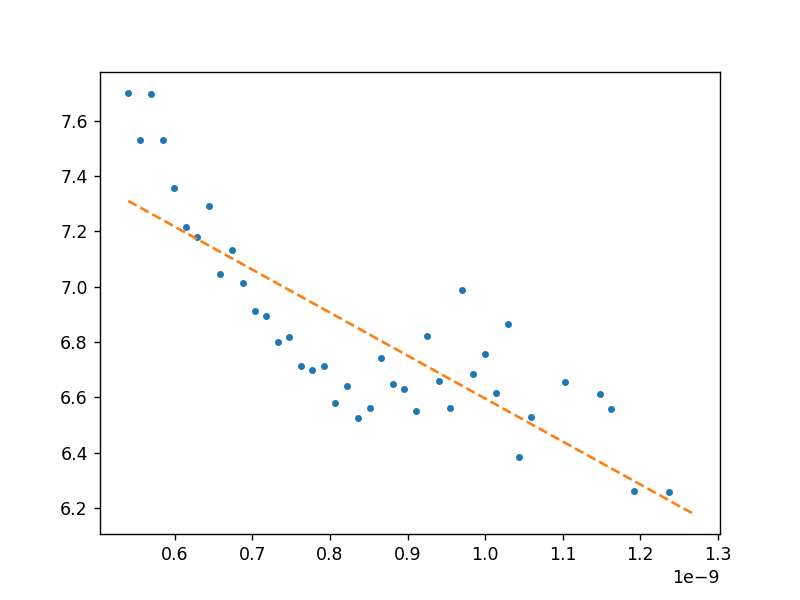

Ic0 = 2.9 nA
Teff = 4.7 mK


<IPython.core.display.Javascript object>


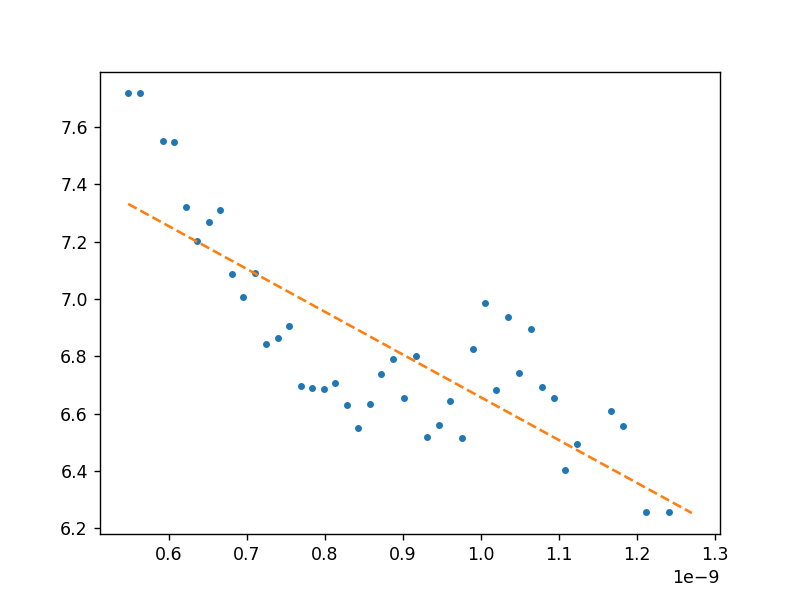

Ic0 = 2.9 nA
Teff = 4.6 mK


<IPython.core.display.Javascript object>


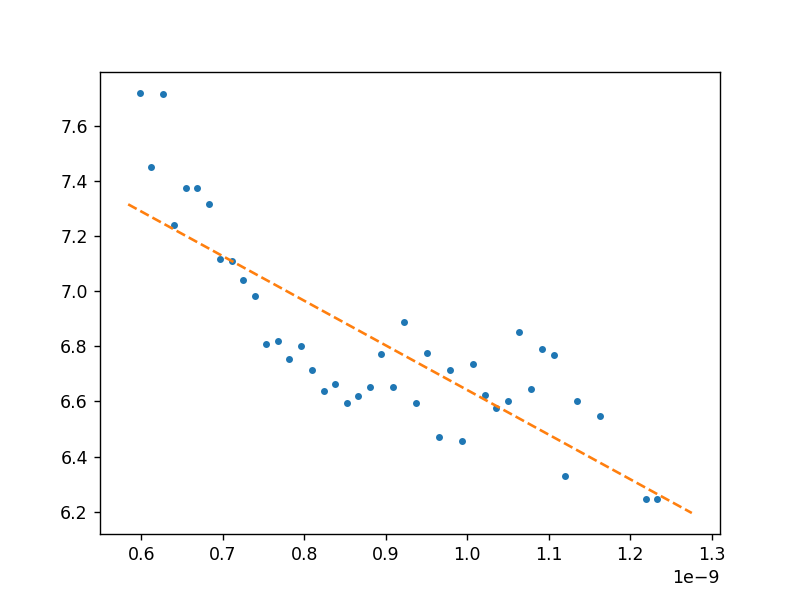

Ic0 = 3.0 nA
Teff = 4.7 mK


<IPython.core.display.Javascript object>


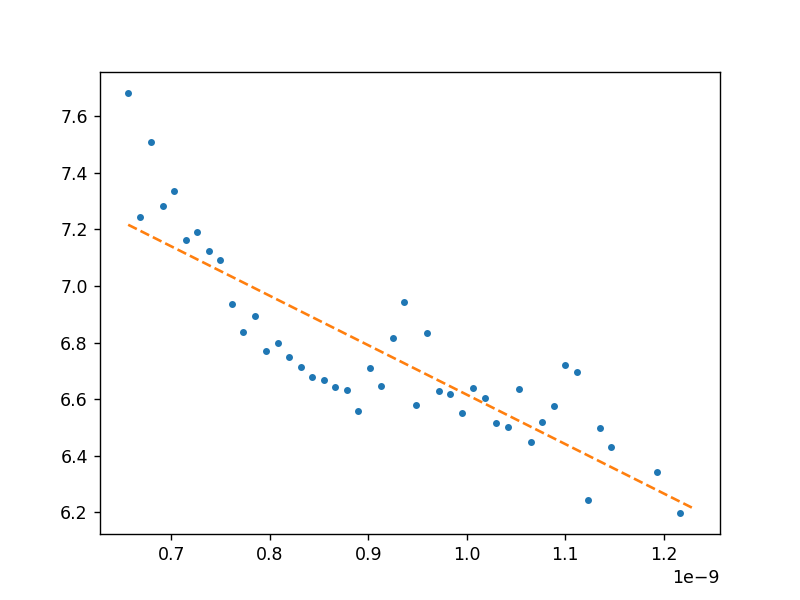

Ic0 = 3.1 nA
Teff = 4.9 mK


<IPython.core.display.Javascript object>


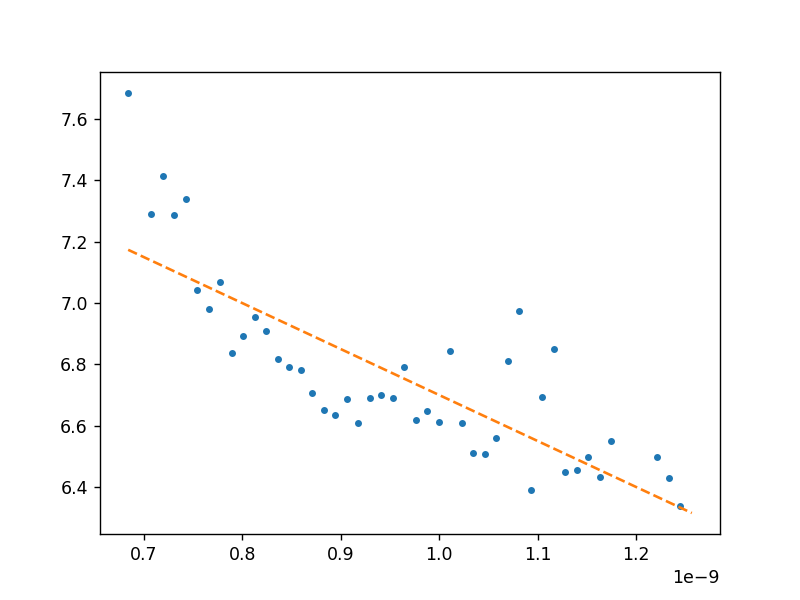

Ic0 = 3.1 nA
Teff = 4.8 mK


<IPython.core.display.Javascript object>


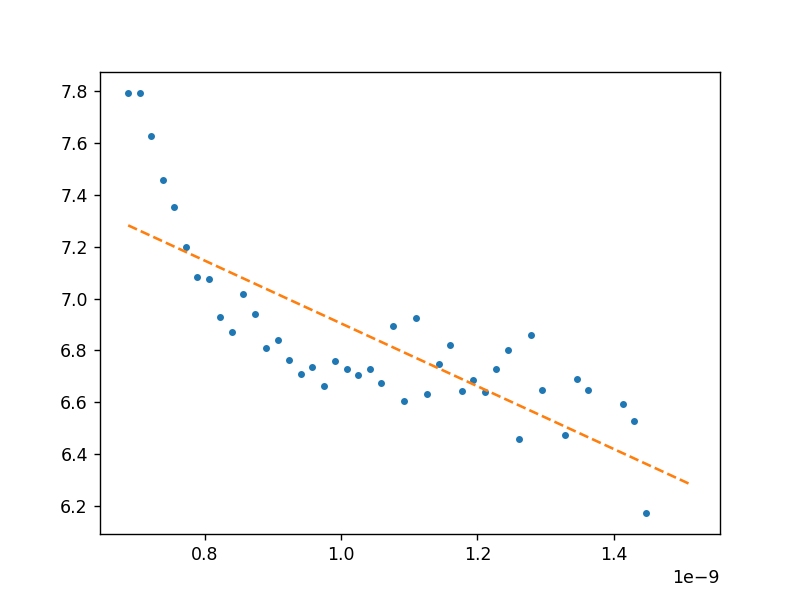

Ic0 = 3.7 nA
Teff = 5.9 mK


<IPython.core.display.Javascript object>


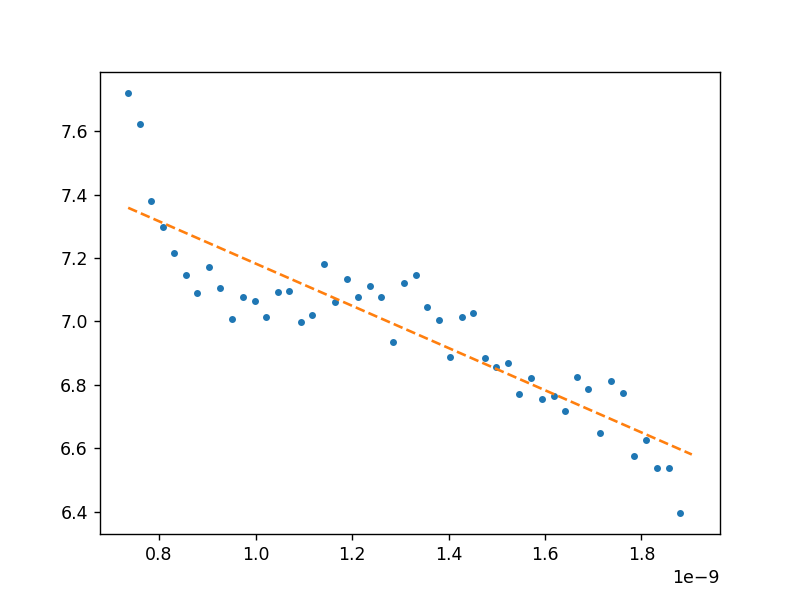

Ic0 = 11.5 nA
Teff = 23.6 mK


<IPython.core.display.Javascript object>


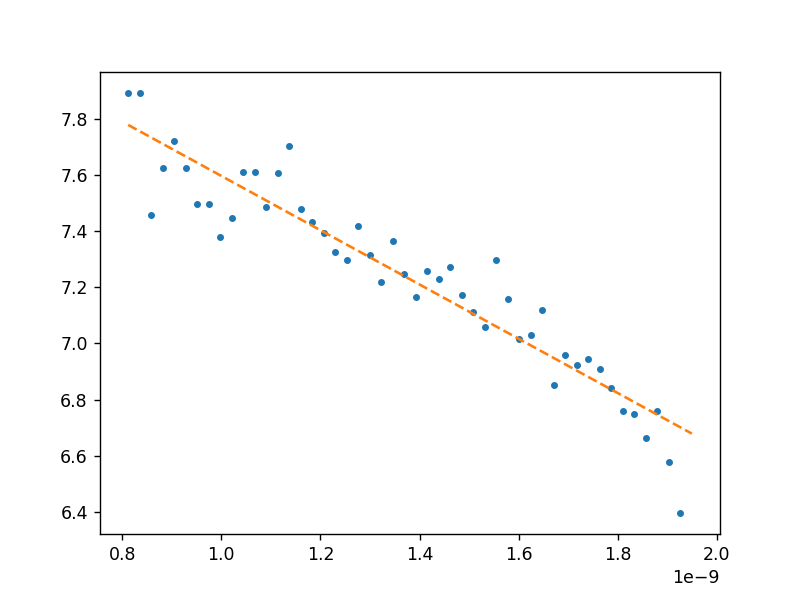

Ic0 = 10.3 nA
Teff = 19.1 mK


In [221]:
eps = .001

exp = exps[0]
for i in range(4,16,1):
    Isw_nan = exp['Isws_n'][i]
    
    Isw = Isw_nan[ np.isfinite(Isw_nan) ]
    

    
    counts, Ibins = np.histogram(Isw, bins = 51)
    dI = np.mean( np.diff(Ibins) )
    dIdt = 30e-9

    SP = np.cumsum(counts)/len(Isw)
    Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


    EJ = .5
    Ec = .05


    Ic = 2*pi*EJ/Φ0*kB
    Ic0 = Ic/2
    Ib = Ibins[:-2]

    while (Ic - Ic0)/Ic > eps:
        
        Ic = Ic0

        wa = wpK(EJ, Ec)*kB/hbar * (1 - (Ib/Ic)**2)**0.25

        coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)

        
#         idx = np.isfinite(coeff) 

#         a, b = np.polyfit( Ib[idx], coeff[idx],1)
        Ib_fit     = np.array_split(Ib,2)   [0]
        coeff_fit = np.array_split(coeff,2) [0]

        idx = np.isfinite(coeff_fit) 



        a, b = np.polyfit( Ib_fit[idx], coeff_fit[idx],1)
        
        Ic0 = -b/a
        Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a

#         print(Ic0, Teff, (Ic - Ic0)/Ic)


    fig, ax = plt.subplots()
    ax.plot(Ib, coeff, '.')

    idx = np.isfinite(coeff) 
    a, b = np.polyfit( Ib[idx], coeff[idx],1)
    
    ax.plot(Ib, a*Ib+b, '--') 
    
    print('Ic0 = {:1.1f} nA'.format(Ic0*1e9))
    print('Teff = {:1.1f} mK'.format(Teff*1e3))